# EDA on Advertising Data

## Look at the structure of the data

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import time    as ti
import itertools
import matplotlib.pyplot as plt

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg         import Vectors
from pyspark.ml.feature        import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml                import Pipeline

from pyspark.sql               import SparkSession, SQLContext
from pyspark.sql.types         import StructType, StructField, BooleanType, IntegerType, StringType, DoubleType, BinaryType
from pyspark.sql.functions     import countDistinct, col, desc, log

In [2]:
ss = SparkSession.builder\
     .config('spark.executor.memory',       '4G')\
     .config('spark.driver.memory',        '40G')\
     .config('spark.driver.maxResultSize', '10G')\
     .getOrCreate()
sc = ss.sparkContext
sq = SQLContext(sc)

In [3]:
schema = StructType()

for f in range(0, 39 + 1):
    if   f == 0 : schema.add(StructField(f'ctr',        IntegerType(), True))
    elif f < 14 : schema.add(StructField(f'i{f   :02}', IntegerType(), True))
    else        : schema.add(StructField(f's{f-13:02}',  StringType(), True))

df = sq.read.format('csv')\
            .options(header = 'true', delimiter = '\t')\
            .schema(schema)\
            .load('../data/train.txt')

num_features = [c for c in df.columns if 'i' in c]
cat_features = [c for c in df.columns if 's' in c]

tf           = df.sample(fraction = 0.01, seed = 2019)

In [4]:
trndf,devdf,tstdf = df.randomSplit([0.8,0.1,0.1],seed=42)

In [246]:
trndf.count()

36673203

In [247]:
devdf.count()

4584676

In [248]:
tstdf.count()

4582737

In [249]:
trndf.write.parquet('../data/train_w261.parquet')

In [250]:
devdf.write.parquet('../data/dev_w261.parquet')

In [251]:
tstdf.write.parquet('../data/test_w261.parquet')

# My EDA

In [4]:
pf = ss.read.parquet('../data/train_w261.parquet')

In [5]:
num_features = [c for c in df.columns if 'i' in c]

In [6]:
ctr_stats = pf.describe(['ctr']).toPandas()

In [8]:
num_summary = pf.describe( num_features ).toPandas()
num_summary = pd.concat([num_summary,ctr_stats],axis=1,sort=False)

In [9]:
num_stats = num_summary.T

In [10]:
num_median = pf.approxQuantile(col=num_features,probabilities=[0.5],relativeError=0.005)
num_median.append([-999])
num_median = list(itertools.chain.from_iterable(num_median))

In [11]:
num_stats= num_stats.rename(columns=num_stats.iloc[0])

In [12]:
num_stats=num_stats.drop(num_stats.index[0])

In [13]:
num_stats['median']=num_median

In [14]:
num_stats['count'] = num_stats['count'].astype(int)

In [15]:
num_stats['mean'] = num_stats['mean'].astype(float)

In [16]:
num_stats['stddev'] = num_stats['stddev'].astype(float)

In [17]:
num_stats['median'] = num_stats['median'].astype(int)

In [18]:
num_stats['min'] = num_stats['min'].astype(float)

In [19]:
num_stats['max'] = num_stats['max'].astype(float)

In [20]:
num_stats.dtypes

count       int64
mean      float64
stddev    float64
min       float64
max       float64
median      int64
dtype: object

In [21]:
num_stats['Pearson2Skew'] = 3*(num_stats['mean']-num_stats['median'])/num_stats['stddev']

In [22]:
num_stats.loc[['ctr'],['median','Pearson2Skew']]= np.nan

In [23]:
num_stats

,count,mean,stddev,min,max,median,Pearson2Skew
i01,20035247,3.500060,9.427662,0.0,5775.0,1.0,0.795550
i02,36673203,105.881091,391.940275,-3.0,257675.0,3.0,0.787475
i03,28802877,26.910415,396.797641,0.0,65535.0,7.0,0.150533
i04,28723574,7.322778,8.799146,0.0,969.0,4.0,1.132875
i05,35725965,18545.307976,69435.515294,0.0,23159456.0,2868.0,0.677347
i06,28469401,116.147388,391.380525,0.0,431037.0,34.0,0.629674
i07,35085776,16.322690,65.524064,0.0,34536.0,4.0,0.564191
i08,36654939,12.517513,16.816877,0.0,6047.0,8.0,0.805889
i09,35085776,106.106119,220.289905,0.0,29019.0,40.0,0.900261
i10,20035247,0.617435,0.683969,0.0,10.0,1.0,-1.677994


# Column Histograms 

In [24]:
idf = pf[num_features].cache()

## i01

In [25]:
i1 = idf.select('i01').cache()

In [26]:
smpl = i1.sample(fraction=0.000005, seed=2019)
smpl.count()

184

In [27]:
smpl1=smpl.withColumn("logi01",log("i01"))
smpl1.show(30)

+----+------------------+
| i01|            logi01|
+----+------------------+
|null|              null|
|null|              null|
|null|              null|
| 0.0|              null|
|null|              null|
|null|              null|
|null|              null|
|null|              null|
|null|              null|
|null|              null|
|null|              null|
| 0.0|              null|
| 4.0|1.3862943611198906|
|null|              null|
|null|              null|
| 4.0|1.3862943611198906|
| 0.0|              null|
|null|              null|
| 7.0|1.9459101490553132|
|13.0|2.5649493574615367|
| 0.0|              null|
|70.0| 4.248495242049359|
|null|              null|
|null|              null|
|null|              null|
|null|              null|
| 0.0|              null|
| 2.0|0.6931471805599453|
|null|              null|
| 0.0|              null|
+----+------------------+
only showing top 30 rows



In [29]:
i1_hist = i1.select('i01').rdd.flatMap(lambda x: x).histogram(5775)

In [30]:
i1_values = i1_hist[0]
i1_values_count = i1_hist[1]

print(f"lengths: i1values={len(i1_values)}, i1counts={len(i1_values_count)}")

lengths: i1values=5776, i1counts=5775


In [31]:
i1_values.pop(0)
print(f"lengths: i1values={len(i1_values)}, i1counts={len(i1_values_count)}")

lengths: i1values=5775, i1counts=5775


In [32]:
i1_smpl = i1.sample(fraction=0.1,seed=42).toPandas()

In [33]:
i1_smpl.describe()

,i01
count,2.001885e+06
mean,3.500289e+00
std,9.391380e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,1.900000e+03


In [ ]:
i1_counts = i1.groupBy('i01').count().toPandas()

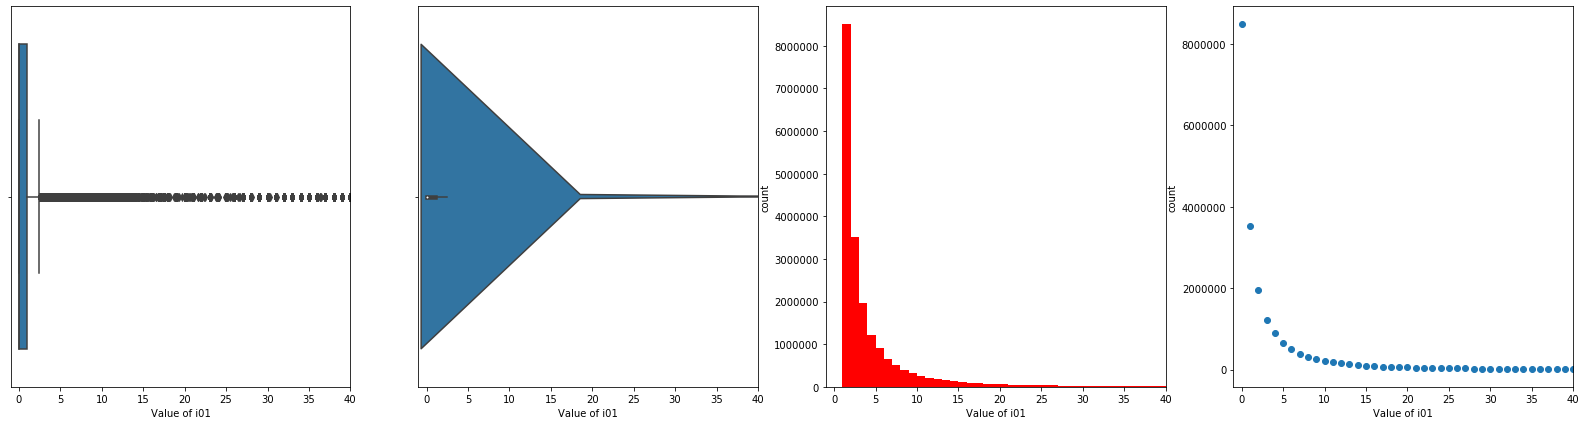

In [392]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i1_smpl)
ax.set(xlim=(-1,40))
ax.set_xlabel('Value of i01')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i1_smpl)
ax.set(xlim=(-1,40))
ax.set_xlabel('Value of i01')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i1_values,len(i1_values),weights=i1_values_count,color='red')
ax.set(xlim=(-1,40))
ax.set_xlabel('Value of i01')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i1_counts['i01'],y=i1_counts['count'])
ax.set(xlim=(-1,40))
ax.set_xlabel('Value of i01')
ax.set_ylabel('count')

plt.show()

In [49]:
i1_smpl['normed']=(i1_smpl['i01'])/(2*9.391380)
i1_smpl.describe()

,i01,normed
count,2.001885e+06,2.001885e+06
mean,3.500289e+00,1.863565e-01
std,9.391380e+00,5.000000e-01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.000000e+00,5.324031e-02
75%,3.000000e+00,1.597209e-01
max,1.900000e+03,1.011566e+02


/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


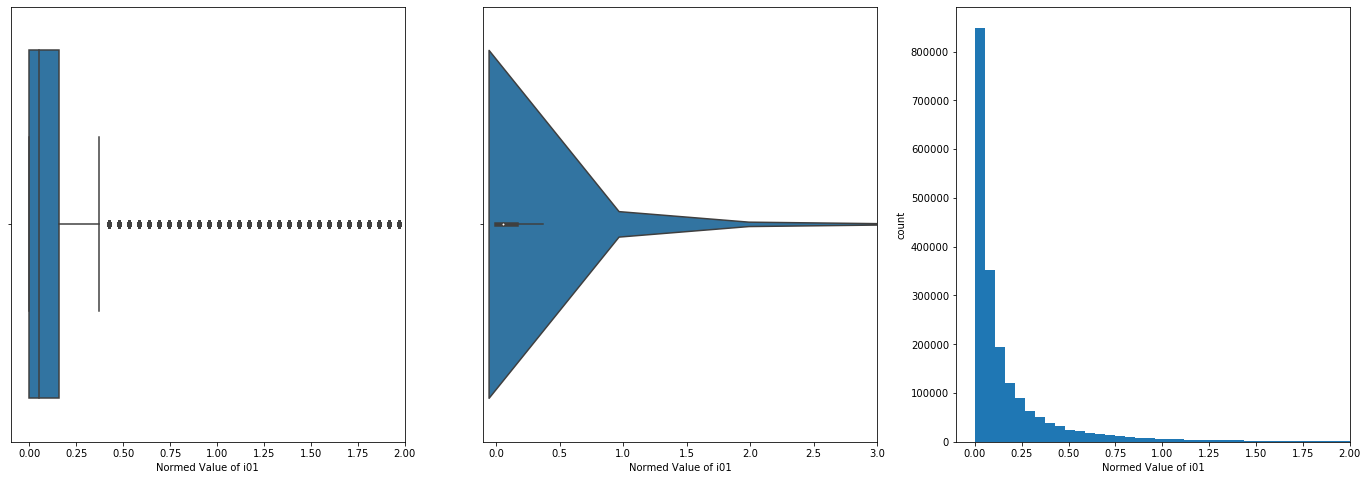

In [393]:
fig=plt.figure(figsize=(24,8))
# Box Plot
ax=fig.add_subplot(1,3,1)
ax=sns.boxplot(x=i1_smpl['normed'])
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i01')

# Violin Plot
ax=fig.add_subplot(1,3,2)
ax=sns.violinplot(x=i1_smpl['normed'])
ax.set(xlim=(-0.1,3))
ax.set_xlabel('Normed Value of i01')

# Histogram
ax=fig.add_subplot(1,3,3)
ax.hist(i1_smpl['normed'],bins=1900)
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i01')
ax.set_ylabel('count')

plt.show()

**Conclusion for i01**
- given the number of 0.0 values (which are NOT null), we cannot log this data, as we introduce a lot more null values
- normalization should only consist of division by 2 times the standard deviation as we don't want to push any values down into the negative, given there are no negative values in the original data

## i02

In [51]:
i2 = idf.select('i02').cache()

In [106]:
negs=i2.filter(i2.i02 == -1)

In [107]:
negs.count()

3771686

In [133]:
i2_counts = i2.groupBy('i02').count().toPandas()

In [136]:
i2_counts.sort_values(by=['count'],ascending=False,inplace=True)
i2_counts.head(10)

,i02,count
8525,0.0,6375260
4648,1.0,5676202
1576,-1.0,3771686
2021,2.0,2102287
2358,3.0,1110591
7443,4.0,805135
454,5.0,651728
4649,6.0,560326
1983,7.0,488975
4928,8.0,435081


In [52]:
smpl2 = i2.sample(fraction=0.000005, seed=2019)
smpl2.count()

184

In [54]:
smpl2=smpl2.withColumn("logi02",log("i02"))
smpl2.show(30)

+------+------------------+
|   i02|            logi02|
+------+------------------+
|1624.0| 7.392647520721623|
|   3.0|1.0986122886681098|
| 302.0|  5.71042701737487|
|   0.0|              null|
|   6.0| 1.791759469228055|
|   0.0|              null|
|   0.0|              null|
|  16.0| 2.772588722239781|
|   0.0|              null|
| 117.0| 4.762173934797756|
|   1.0|               0.0|
|   1.0|               0.0|
|   2.0|0.6931471805599453|
|   1.0|               0.0|
|   1.0|               0.0|
|  37.0|3.6109179126442243|
|   3.0|1.0986122886681098|
| 277.0|5.6240175061873385|
|  75.0|  4.31748811353631|
| 210.0|5.3471075307174685|
|   1.0|               0.0|
|   0.0|              null|
|  11.0|2.3978952727983707|
|   0.0|              null|
|   1.0|               0.0|
| 136.0| 4.912654885736052|
|   1.0|               0.0|
|   0.0|              null|
|  -1.0|              null|
|   1.0|               0.0|
+------+------------------+
only showing top 30 rows



In [86]:
i2_hist = i2.select('i02').rdd.flatMap(lambda x: x).histogram(20000)

In [87]:
i2_values = i2_hist[0]
i2_values_count = i2_hist[1]

print(f"lengths: i2values={len(i2_values)}, i2counts={len(i2_values_count)}")

lengths: i2values=20001, i2counts=20000


In [88]:
i2_values.pop(0)
print(f"lengths: i2values={len(i2_values)}, i2counts={len(i2_values_count)}")

lengths: i2values=20000, i2counts=20000


In [59]:
i2_smpl = i2.sample(fraction=0.1,seed=42).toPandas()

In [60]:
i2_smpl.describe()

,i02
count,3.665299e+06
mean,1.058606e+02
std,3.885554e+02
min,-3.000000e+00
25%,0.000000e+00
50%,3.000000e+00
75%,3.500000e+01
max,1.549900e+04


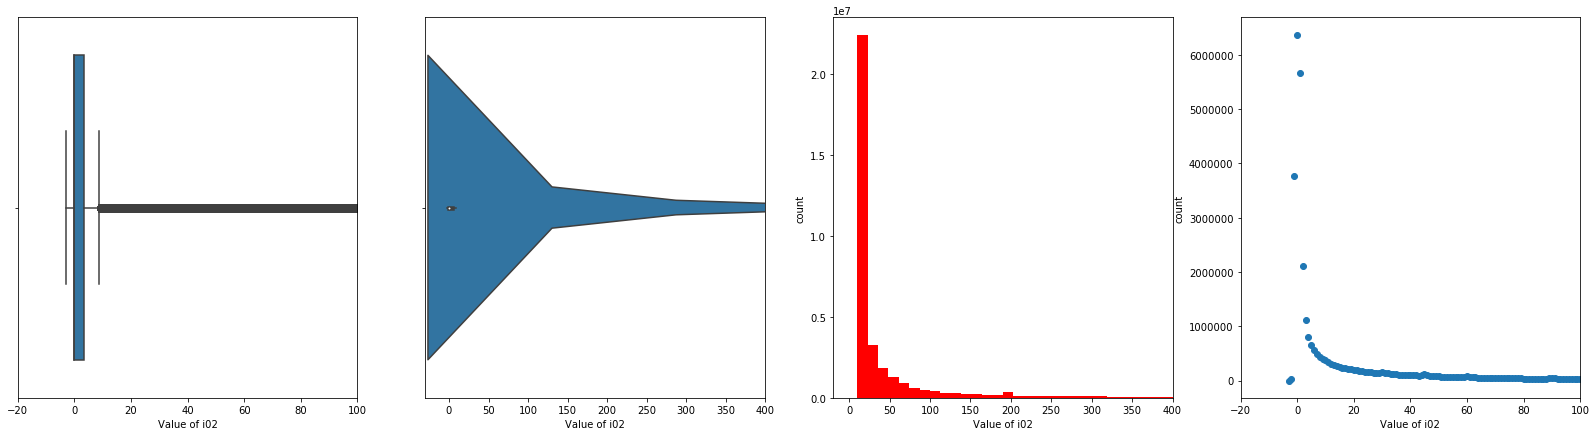

In [395]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i2_smpl)
ax.set(xlim=(-20,100))
ax.set_xlabel('Value of i02')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i2_smpl)
ax.set(xlim=(-30,400))
ax.set_xlabel('Value of i02')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i2_values,len(i2_values),weights=i2_values_count,color='red')
ax.set(xlim=(-20,400))
ax.set_xlabel('Value of i02')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i2_counts['i02'],y=i2_counts['count'])
ax.set(xlim=(-20,100))
ax.set_xlabel('Value of i02')
ax.set_ylabel('count')

plt.show()

In [396]:
i2_smpl['normed']=(i2_smpl['i02']-3)/(391.940275)
i2_smpl.describe()

,i02,normed
count,3.665299e+06,3.665299e+06
mean,1.058606e+02,2.624393e-01
std,3.885554e+02,9.913637e-01
min,-3.000000e+00,-1.530845e-02
25%,0.000000e+00,-7.654227e-03
50%,3.000000e+00,0.000000e+00
75%,3.500000e+01,8.164509e-02
max,1.549900e+04,3.953664e+01


In [397]:
i2_normed_counts = i2_counts

In [398]:
i2_normed_counts['normed']=(i2_normed_counts['i02']-3)/(391.940275)

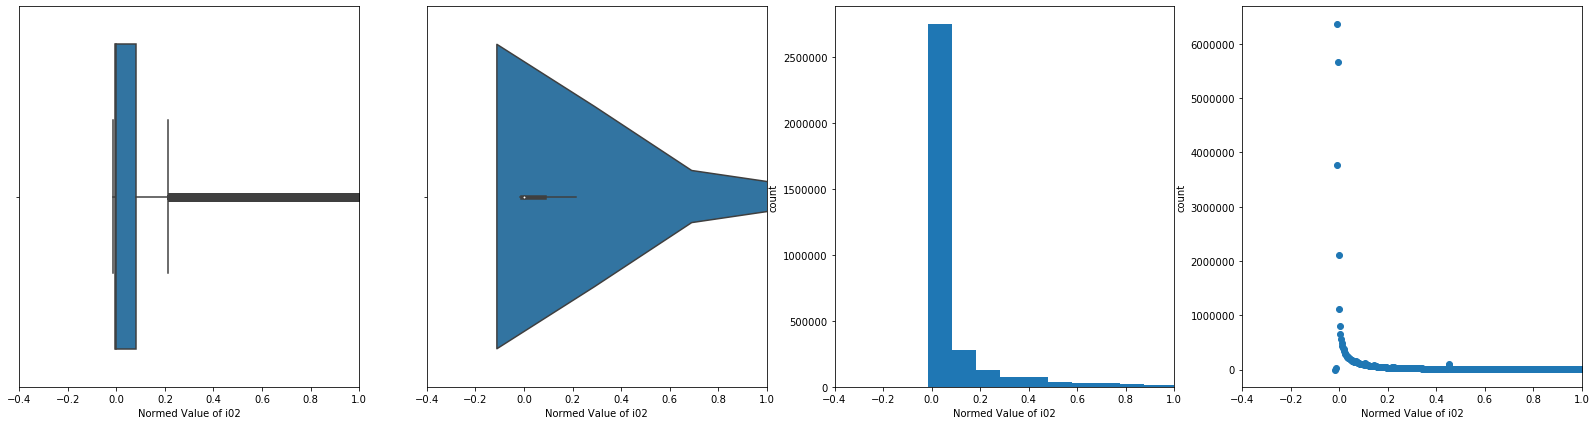

In [399]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i2_smpl['normed'])
ax.set(xlim=(-0.4,1))
ax.set_xlabel('Normed Value of i02')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i2_smpl['normed'])
ax.set(xlim=(-0.4,1))
ax.set_xlabel('Normed Value of i02')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i2_smpl['normed'],bins=400)
ax.set(xlim=(-0.4,1))
ax.set_xlabel('Normed Value of i02')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i2_normed_counts['normed'],y=i2_normed_counts['count'])
ax.set(xlim=(-0.4,1))
ax.set_xlabel('Normed Value of i02')
ax.set_ylabel('count')


plt.show()

**Conclusion for i02**
- given the number of negative values (~3 million -1's) this data is a very skewed 'normal' distribution.
- with the negative numbers we will not be able to log the data
- normalization here will consist of the Z-score with median = (value-median)/StdDev.

## i03

In [147]:
i3 = idf.select('i03').cache()

In [148]:
i3_counts = i3.groupBy('i03').count().toPandas()

In [149]:
i3_counts.sort_values(by=['count'],ascending=False,inplace=True)
i3_counts.head(10)

,i03,count
2717,NaN,7870326
6743,1.0,4596431
2923,2.0,3140725
3415,3.0,2347058
10796,4.0,1856517
644,5.0,1490140
6746,6.0,1234044
2866,7.0,1071076
7122,8.0,907755
435,9.0,796039


In [152]:
i3_counts.shape

(13000, 2)

In [159]:
zeroes = i3_counts[i3_counts['i03']==0]

In [161]:
zeroes

,i03,count
12398,0.0,126563


In [150]:
smpl3 = i3.sample(fraction=0.000005, seed=2019)
smpl3.count()

184

In [151]:
smpl3=smpl3.withColumn("logi03",log("i03"))
smpl3.show(30)

+-----+------------------+
|  i03|            logi03|
+-----+------------------+
|  1.0|               0.0|
|  9.0|2.1972245773362196|
|  3.0|1.0986122886681098|
|  1.0|               0.0|
|  1.0|               0.0|
|  1.0|               0.0|
|  6.0| 1.791759469228055|
| null|              null|
|  6.0| 1.791759469228055|
|  3.0|1.0986122886681098|
|  4.0|1.3862943611198906|
| 29.0| 3.367295829986474|
|  4.0|1.3862943611198906|
| null|              null|
|  7.0|1.9459101490553132|
|110.0| 4.700480365792417|
| 15.0|  2.70805020110221|
|  1.0|               0.0|
|  4.0|1.3862943611198906|
|  2.0|0.6931471805599453|
|  1.0|               0.0|
| 30.0|3.4011973816621555|
|  8.0|2.0794415416798357|
|  4.0|1.3862943611198906|
| 25.0|3.2188758248682006|
|  7.0|1.9459101490553132|
|  1.0|               0.0|
|119.0|  4.77912349311153|
| null|              null|
| 44.0| 3.784189633918261|
+-----+------------------+
only showing top 30 rows



In [153]:
i3_hist = i3.select('i03').rdd.flatMap(lambda x: x).histogram(15000)

In [154]:
i3_values = i3_hist[0]
i3_values_count = i3_hist[1]
i3_values.pop(0)
print(f"lengths: i3values={len(i3_values)}, i3counts={len(i3_values_count)}")

lengths: i3values=15000, i3counts=15000


In [155]:
i3_smpl = i3.sample(fraction=0.1,seed=42).toPandas()

In [156]:
i3_smpl.describe()

,i03
count,2.879164e+06
mean,2.699090e+01
std,3.966348e+02
min,0.000000e+00
25%,2.000000e+00
50%,6.000000e+00
75%,1.800000e+01
max,6.553500e+04


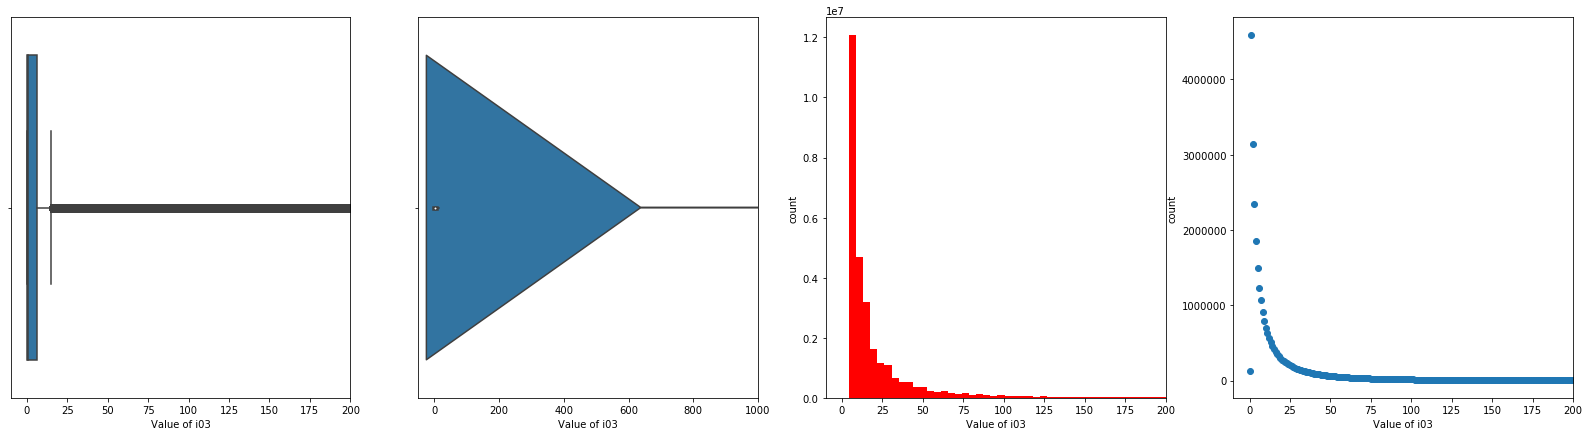

In [402]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i3_smpl)
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i03')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i3_smpl)
ax.set(xlim=(-50,1000))
ax.set_xlabel('Value of i03')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i3_values,len(i3_values),weights=i3_values_count,color='red')
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i03')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i3_counts['i03'],y=i3_counts['count'])
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i03')
ax.set_ylabel('count')

plt.show()

In [174]:
i3_smpl['normed']=(i3_smpl['i03'])/(396.797641)
i3_smpl.describe()

,i03,normed
count,2.879164e+06,2.879164e+06
mean,2.699090e+01,6.802179e-02
std,3.966348e+02,9.995896e-01
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.040353e-03
50%,6.000000e+00,1.512106e-02
75%,1.800000e+01,4.536317e-02
max,6.553500e+04,1.651598e+02


In [164]:
i3_normed_counts = i3_counts

In [175]:
i3_normed_counts['normed']=(i3_normed_counts['i03'])/(396.797641)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


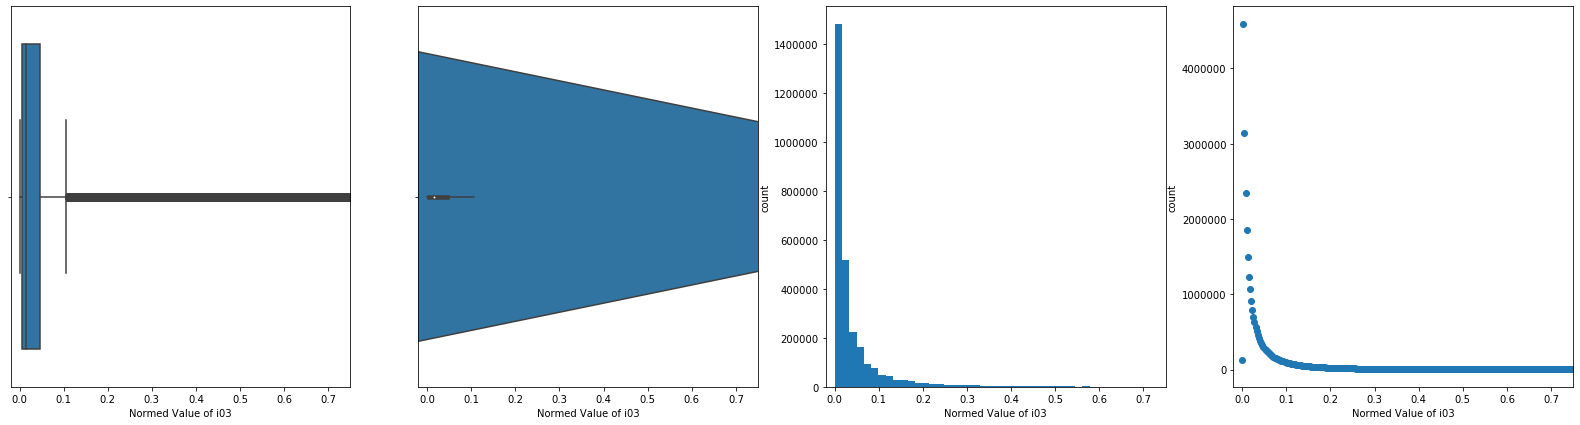

In [177]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i3_smpl['normed'])
ax.set(xlim=(-0.02,0.75))
ax.set_xlabel('Normed Value of i03')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i3_smpl['normed'])
ax.set(xlim=(-0.02,0.75))
ax.set_xlabel('Normed Value of i03')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i3_smpl['normed'],bins=10000)
ax.set(xlim=(-0.02,0.75))
ax.set_xlabel('Normed Value of i03')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i3_normed_counts['normed'],y=i3_normed_counts['count'])
ax.set(xlim=(-0.02,0.75))
ax.set_xlabel('Normed Value of i03')
ax.set_ylabel('count')


plt.show()

**Conclusion for i03**
- exponentially decreasing function
- normalization here will consist of dividing by the stddev

## i04

In [171]:
i4 = idf.select('i04').cache()

In [172]:
i4_counts = i4.groupBy('i04').count().toPandas()

In [173]:
i4_counts.sort_values(by=['count'],ascending=False,inplace=True)
i4_counts.head(10)

,i04,count
94,NaN,7949629
233,1.0,4793853
101,2.0,3688504
118,3.0,2792364
382,4.0,2237053
20,5.0,1776087
448,0.0,1550410
234,6.0,1497171
100,7.0,1230103
247,8.0,1040946


In [178]:
i4_counts.shape

(466, 2)

In [179]:
zeroes = i4_counts[i4_counts['i04']==0]

In [180]:
zeroes

,i04,count
448,0.0,1550410


In [183]:
i4_hist = i4.select('i04').rdd.flatMap(lambda x: x).histogram(500)

In [184]:
i4_values = i4_hist[0]
i4_values_count = i4_hist[1]
i4_values.pop(0)
print(f"lengths: i4values={len(i4_values)}, i4counts={len(i4_values_count)}")

lengths: i4values=500, i4counts=500


In [185]:
i4_smpl = i4.sample(fraction=0.1,seed=42).toPandas()

In [186]:
i4_smpl.describe()

,i04
count,2.870505e+06
mean,7.321034e+00
std,8.767357e+00
min,0.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,1.000000e+01
max,7.240000e+02


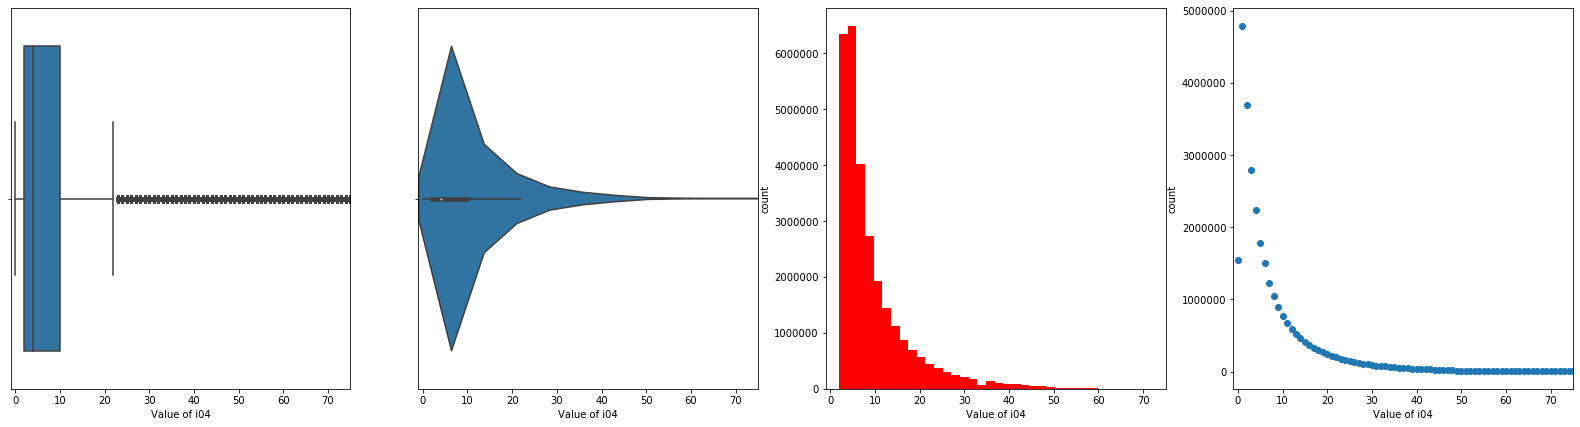

In [188]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i4_smpl)
ax.set(xlim=(-1,75))
ax.set_xlabel('Value of i04')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i4_smpl)
ax.set(xlim=(-1,75))
ax.set_xlabel('Value of i04')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i4_values,len(i4_values),weights=i4_values_count,color='red')
ax.set(xlim=(-1,75))
ax.set_xlabel('Value of i04')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i4_counts['i04'],y=i4_counts['count'])
ax.set(xlim=(-1,75))
ax.set_xlabel('Value of i04')
ax.set_ylabel('count')

plt.show()

In [204]:
i4_smpl['normed']=(i4_smpl['i04']-4)/(8.799146)
i4_smpl.describe()

,i04,normed
count,2.870505e+06,2.870505e+06
mean,7.321034e+00,3.774268e-01
std,8.767357e+00,9.963872e-01
min,0.000000e+00,-4.545896e-01
25%,2.000000e+00,-2.272948e-01
50%,4.000000e+00,0.000000e+00
75%,1.000000e+01,6.818844e-01
max,7.240000e+02,8.182612e+01


In [195]:
i4_normed_counts = i4_counts

In [205]:
i4_normed_counts['normed']=(i4_normed_counts['i04']-4)/(8.799146)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


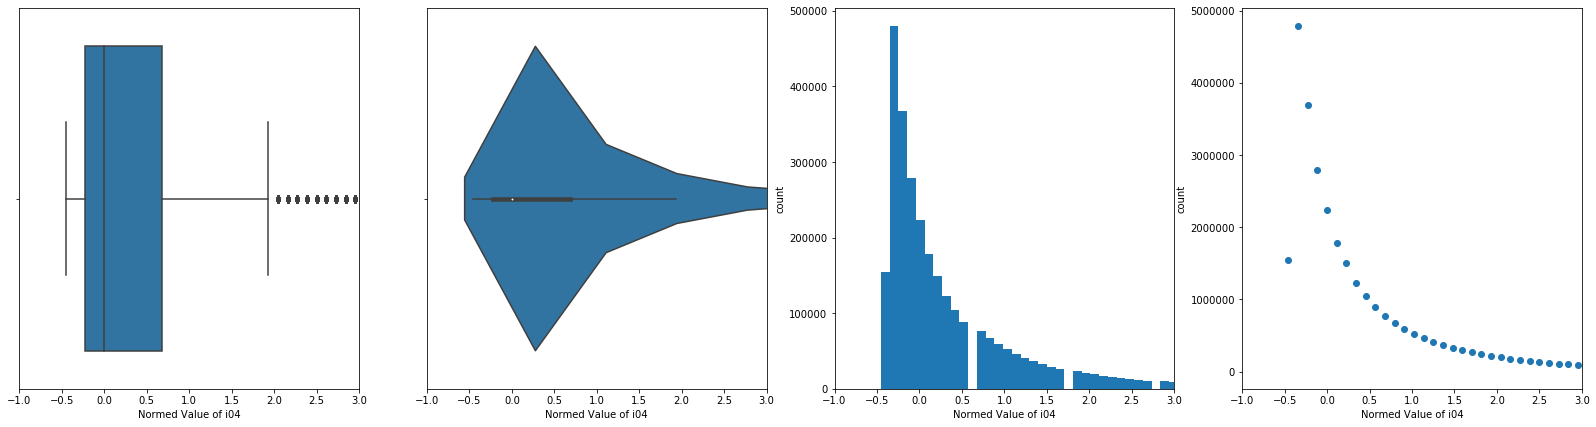

In [206]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i4_smpl['normed'])
ax.set(xlim=(-1,3))
ax.set_xlabel('Normed Value of i04')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i4_smpl['normed'])
ax.set(xlim=(-1,3))
ax.set_xlabel('Normed Value of i04')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i4_smpl['normed'],bins=800)
ax.set(xlim=(-1,3))
ax.set_xlabel('Normed Value of i04')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i4_normed_counts['normed'],y=i4_normed_counts['count'])
ax.set(xlim=(-1,3))
ax.set_xlabel('Normed Value of i04')
ax.set_ylabel('count')


plt.show()

**Conclusion for i04**
- This is obviously a normal distribution (albeit skewed), given the violin plot.
- normalization here will consist of the z-score, but using median, not mean, due to the skew

## i05

In [207]:
i5 = idf.select('i05').cache()

In [208]:
i5_counts = i5.groupBy('i05').count().toPandas()

In [213]:
i5_counts.sort_values(by=['count'],ascending=False,inplace=True)
i5_counts.head(15)

,i05,count
93127,NaN,947238
232999,1.0,831827
424110,0.0,662901
99854,2.0,543193
370435,4.0,404734
22160,5.0,326309
97611,7.0,279994
246101,8.0,242426
159846,10.0,214007
90962,11.0,161282


In [210]:
i5_counts.shape

(443955, 2)

In [214]:
zeroes = i5_counts[i5_counts['i05']==0]

In [215]:
zeroes

,i05,count
424110,0.0,662901


In [222]:
i5_hist = i5.select('i05').rdd.flatMap(lambda x: x).histogram(25000)

In [223]:
i5_values = i5_hist[0]
i5_values_count = i5_hist[1]
i5_values.pop(0)
print(f"lengths: i5values={len(i5_values)}, i5counts={len(i5_values_count)}")

lengths: i5values=25000, i5counts=25000


In [219]:
i5_smpl = i5.sample(fraction=0.1,seed=42).toPandas()

In [220]:
i5_smpl.describe()

,i05
count,3.570740e+06
mean,1.854395e+04
std,6.930684e+04
min,0.000000e+00
25%,3.280000e+02
50%,2.813000e+03
75%,1.013100e+04
max,2.678025e+06


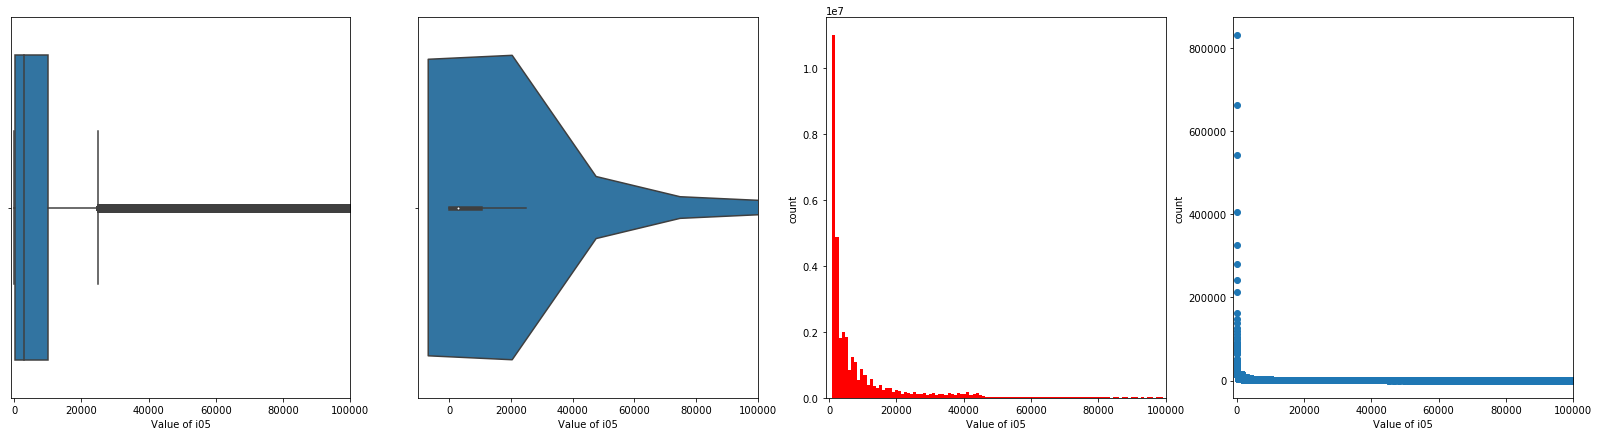

In [226]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i5_smpl)
ax.set(xlim=(-1000,100000))
ax.set_xlabel('Value of i05')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i5_smpl)
ax.set(xlim=(-10000,100000))
ax.set_xlabel('Value of i05')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i5_values,len(i5_values),weights=i5_values_count,color='red')
ax.set(xlim=(-1000,100000))
ax.set_xlabel('Value of i05')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i5_counts['i05'],y=i5_counts['count'])
ax.set(xlim=(-1000,100000))
ax.set_xlabel('Value of i05')
ax.set_ylabel('count')

plt.show()

In [227]:
i5_smpl['normed']=(i5_smpl['i05']-2868)/(69435)
i5_smpl.describe()

,i05,normed
count,3.570740e+06,3.570740e+06
mean,1.854395e+04,2.257644e-01
std,6.930684e+04,9.981542e-01
min,0.000000e+00,-4.130482e-02
25%,3.280000e+02,-3.658098e-02
50%,2.813000e+03,-7.921077e-04
75%,1.013100e+04,1.046014e-01
max,2.678025e+06,3.852750e+01


In [228]:
i5_normed_counts = i5_counts

In [230]:
i5_normed_counts['normed']=(i5_normed_counts['i05']-2868)/(69435)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


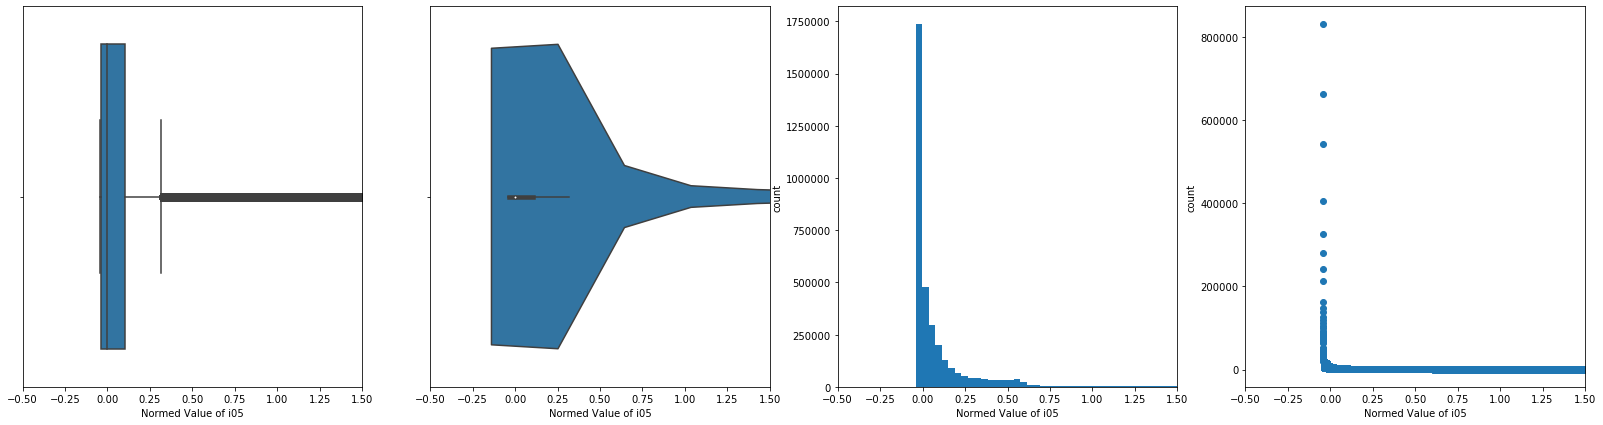

In [232]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i5_smpl['normed'])
ax.set(xlim=(-0.5,1.5))
ax.set_xlabel('Normed Value of i05')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i5_smpl['normed'])
ax.set(xlim=(-0.5,1.5))
ax.set_xlabel('Normed Value of i05')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i5_smpl['normed'],bins=1000)
ax.set(xlim=(-0.5,1.5))
ax.set_xlabel('Normed Value of i05')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i5_normed_counts['normed'],y=i5_normed_counts['count'])
ax.set(xlim=(-0.5,1.5))
ax.set_xlabel('Normed Value of i05')
ax.set_ylabel('count')


plt.show()

**Conclusion for i05**
- Treating this as a skewed normal distribution, given the violin plot.
- normalization here will consist of the z-score, but using median, not mean, due to the skew

## i06

In [233]:
i6 = idf.select('i06').cache()

In [234]:
i6_counts = i6.groupBy('i06').count().toPandas()

In [235]:
i6_counts.sort_values(by=['count'],ascending=False,inplace=True)
i6_counts.head(15)

,i06,count
2277,NaN,8203802
10469,0.0,1852044
5710,1.0,988659
2451,2.0,884514
2870,3.0,765317
9139,4.0,677963
527,5.0,605051
5711,6.0,561480
2397,7.0,514513
6059,8.0,476888


In [236]:
i6_counts.shape

(10965, 2)

In [237]:
i6_hist = i6.select('i06').rdd.flatMap(lambda x: x).histogram(5000)

In [238]:
i6_values = i6_hist[0]
i6_values_count = i6_hist[1]
i6_values.pop(0)
print(f"lengths: i6values={len(i6_values)}, i6counts={len(i6_values_count)}")

lengths: i6values=5000, i6counts=5000


In [239]:
i6_smpl = i6.sample(fraction=0.1,seed=42).toPandas()

In [240]:
i6_smpl.describe()

,i06
count,2.846626e+06
mean,1.167467e+02
std,5.167589e+02
min,0.000000e+00
25%,8.000000e+00
50%,3.300000e+01
75%,1.020000e+02
max,4.310370e+05


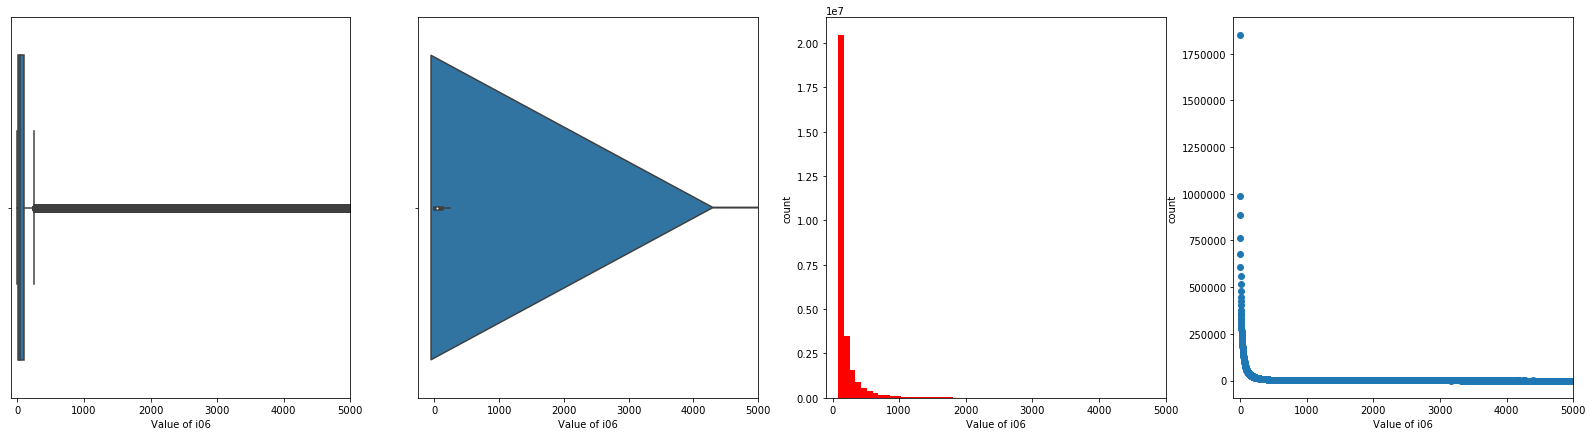

In [243]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i6_smpl)
ax.set(xlim=(-100,5000))
ax.set_xlabel('Value of i06')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i6_smpl)
ax.set(xlim=(-250,5000))
ax.set_xlabel('Value of i06')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i6_values,len(i6_values),weights=i6_values_count,color='red')
ax.set(xlim=(-100,5000))
ax.set_xlabel('Value of i06')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i6_counts['i06'],y=i6_counts['count'])
ax.set(xlim=(-100,5000))
ax.set_xlabel('Value of i06')
ax.set_ylabel('count')

plt.show()

In [244]:
i6_smpl['normed']=(i6_smpl['i06'])/(2*391.38)
i6_smpl.describe()

,i06,normed
count,2.846626e+06,2.846626e+06
mean,1.167467e+02,1.491474e-01
std,5.167589e+02,6.601754e-01
min,0.000000e+00,0.000000e+00
25%,8.000000e+00,1.022025e-02
50%,3.300000e+01,4.215852e-02
75%,1.020000e+02,1.303081e-01
max,4.310370e+05,5.506630e+02


In [246]:
i6_normed_counts = i6_counts

In [247]:
i6_normed_counts['normed']=(i6_normed_counts['i06'])/(2*391.38)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


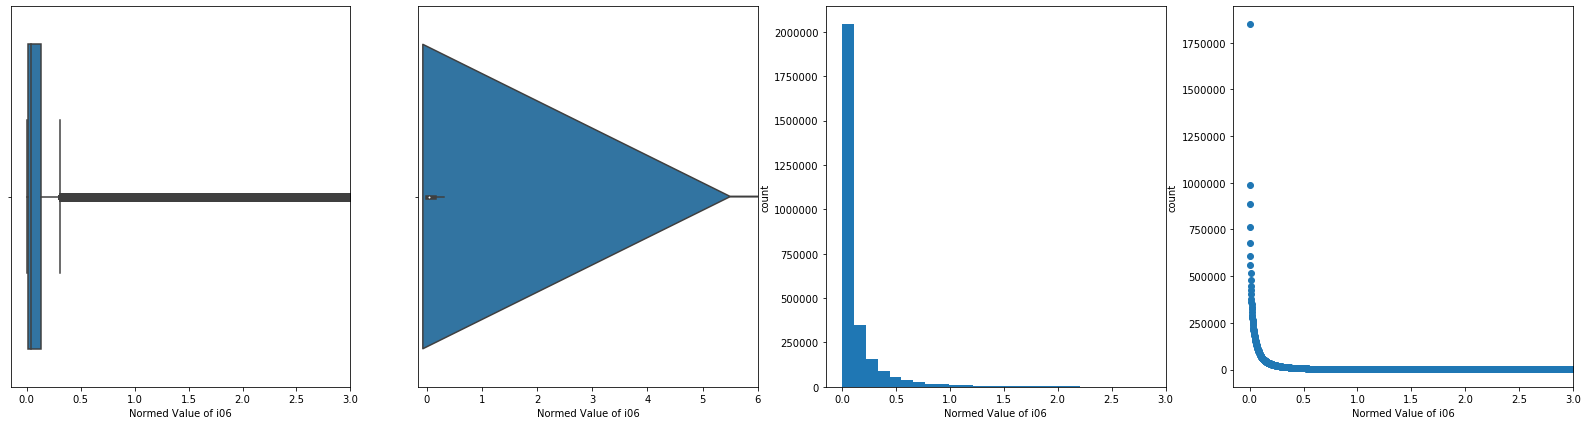

In [250]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i6_smpl['normed'])
ax.set(xlim=(-0.15,3))
ax.set_xlabel('Normed Value of i06')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i6_smpl['normed'])
ax.set(xlim=(-0.15,6))
ax.set_xlabel('Normed Value of i06')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i6_smpl['normed'],bins=5000)
ax.set(xlim=(-0.15,3))
ax.set_xlabel('Normed Value of i06')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i6_normed_counts['normed'],y=i6_normed_counts['count'])
ax.set(xlim=(-0.15,3))
ax.set_xlabel('Normed Value of i06')
ax.set_ylabel('count')

plt.show()

**Conclusion for i06**
- Exponentially decreasing distribution
- normalization here will consist of dividing by 2 times the std. deviation.

## i07

In [251]:
i7 = idf.select('i07').cache()

In [252]:
i7_counts = i7.groupBy('i07').count().toPandas()

In [253]:
i7_counts.sort_values(by=['count'],ascending=False,inplace=True)
i7_counts.head(15)

,i07,count
3730,0.0,7925427
1997,1.0,4749720
867,2.0,3171862
1007,3.0,2162133
3232,4.0,1868476
812,NaN,1587427
197,5.0,1440369
1998,6.0,1227964
854,7.0,990499
2128,8.0,873173


In [254]:
i7_counts.shape

(3911, 2)

In [255]:
i7_hist = i7.select('i07').rdd.flatMap(lambda x: x).histogram(5000)

In [256]:
i7_values = i7_hist[0]
i7_values_count = i7_hist[1]
i7_values.pop(0)
print(f"lengths: i7values={len(i7_values)}, i7counts={len(i7_values_count)}")

lengths: i7values=5000, i7counts=5000


In [257]:
i7_smpl = i7.sample(fraction=0.1,seed=42).toPandas()

In [258]:
i7_smpl.describe()

,i07
count,3.506665e+06
mean,1.629872e+01
std,6.543667e+01
min,0.000000e+00
25%,1.000000e+00
50%,3.000000e+00
75%,1.100000e+01
max,1.183900e+04


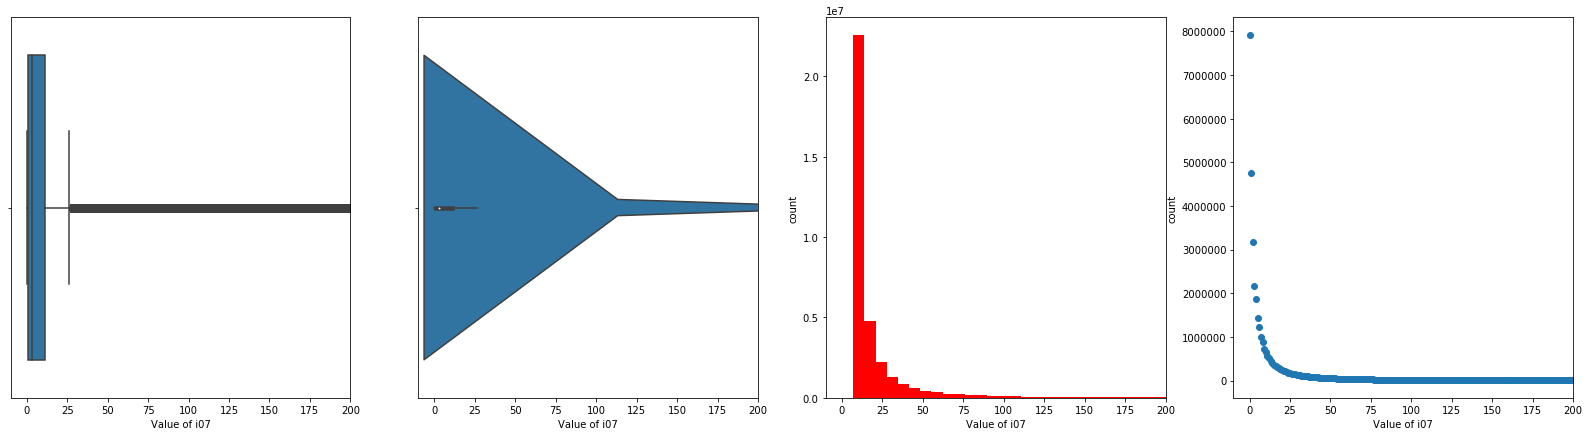

In [260]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i7_smpl)
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i07')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i7_smpl)
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i07')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i7_values,len(i7_values),weights=i7_values_count,color='red')
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i07')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i7_counts['i07'],y=i7_counts['count'])
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i07')
ax.set_ylabel('count')

plt.show()

In [261]:
i7_smpl['normed']=(i7_smpl['i07'])/(2*65.524)
i7_smpl.describe()

,i07,normed
count,3.506665e+06,3.506665e+06
mean,1.629872e+01,1.243722e-01
std,6.543667e+01,4.993336e-01
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,7.630792e-03
50%,3.000000e+00,2.289238e-02
75%,1.100000e+01,8.393871e-02
max,1.183900e+04,9.034094e+01


In [262]:
i7_normed_counts = i7_counts

In [263]:
i7_normed_counts['normed']=(i7_normed_counts['i07'])/(2*65.524)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


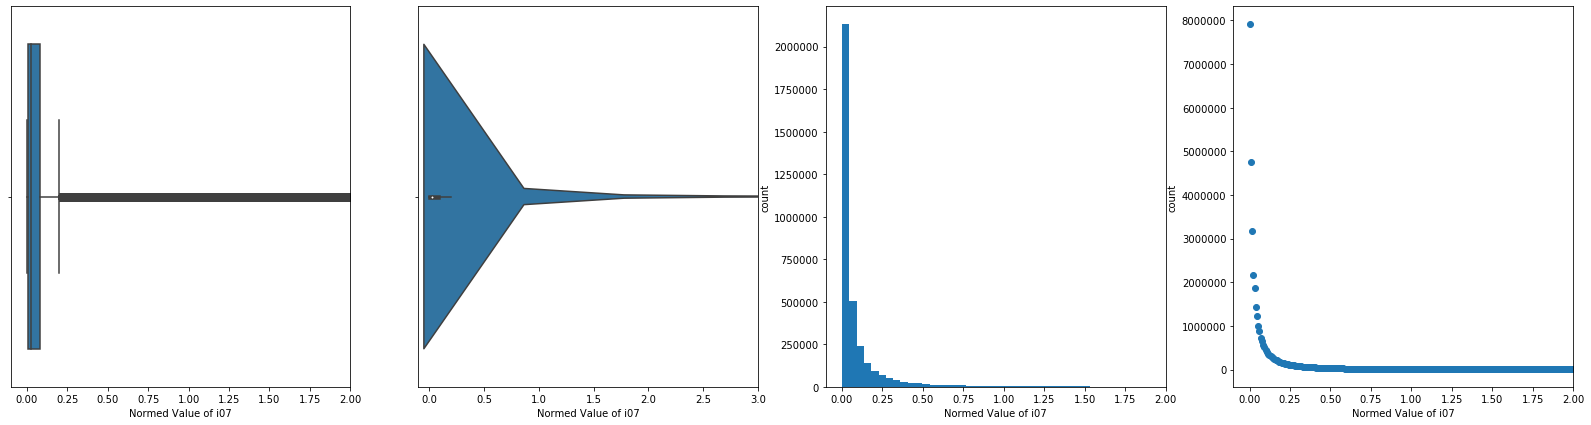

In [265]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i7_smpl['normed'])
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i07')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i7_smpl['normed'])
ax.set(xlim=(-0.1,3))
ax.set_xlabel('Normed Value of i07')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i7_smpl['normed'],bins=2000)
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i07')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i7_normed_counts['normed'],y=i7_normed_counts['count'])
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i07')
ax.set_ylabel('count')

plt.show()

**Conclusion for i07**
- Exponentially decreasing distribution
- normalization here will consist of dividing by 2 times the std. deviation.

## i08

In [268]:
i8 = idf.select('i08').cache()

In [269]:
i8_counts = i8.groupBy('i08').count().toPandas()

In [270]:
i8_counts.sort_values(by=['count'],ascending=False,inplace=True)
i8_counts.head(15)

,i08,count
1214,0.0,4206637
643,1.0,3007041
281,2.0,2557140
331,3.0,2175604
1027,4.0,1966761
56,5.0,1697724
644,6.0,1573552
277,7.0,1437268
680,8.0,1099478
35,9.0,1015914


In [272]:
i8_counts.shape

(1274, 2)

In [273]:
i8_hist = i8.select('i08').rdd.flatMap(lambda x: x).histogram(1200)

In [274]:
i8_values = i8_hist[0]
i8_values_count = i8_hist[1]
i8_values.pop(0)
print(f"lengths: i8values={len(i8_values)}, i8counts={len(i8_values_count)}")

lengths: i8values=1200, i8counts=1200


In [275]:
i8_smpl = i8.sample(fraction=0.1,seed=42).toPandas()

In [276]:
i8_smpl.describe()

,i08
count,3.663399e+06
mean,1.252531e+01
std,1.718326e+01
min,0.000000e+00
25%,2.000000e+00
50%,7.000000e+00
75%,1.900000e+01
max,4.839000e+03


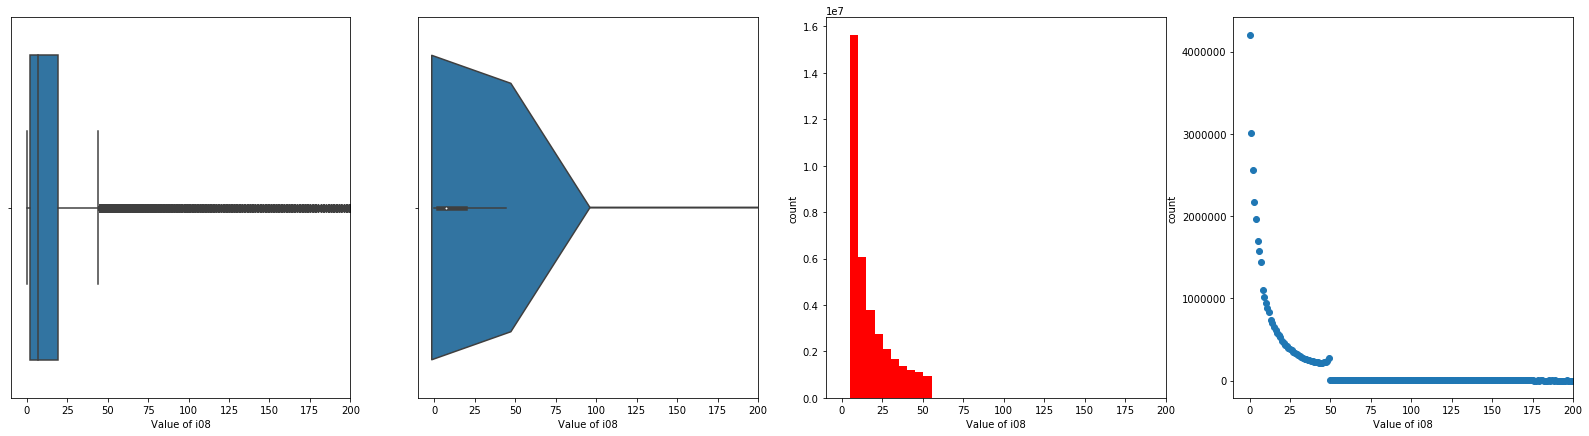

In [281]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i8_smpl)
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i08')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i8_smpl)
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i08')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i8_values,len(i8_values),weights=i8_values_count,color='red')
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i08')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i8_counts['i08'],y=i8_counts['count'])
ax.set(xlim=(-10,200))
ax.set_xlabel('Value of i08')
ax.set_ylabel('count')

plt.show()

In [282]:
i8_smpl['normed']=(i8_smpl['i08'])/(2*16.816877)
i8_smpl.describe()

,i08,normed
count,3.663399e+06,3.663399e+06
mean,1.252531e+01,3.724031e-01
std,1.718326e+01,5.108932e-01
min,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.946407e-02
50%,7.000000e+00,2.081243e-01
75%,1.900000e+01,5.649087e-01
max,4.839000e+03,1.438733e+02


In [283]:
i8_normed_counts = i8_counts

In [284]:
i8_normed_counts['normed']=(i8_normed_counts['i08'])/(2*16.816877)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


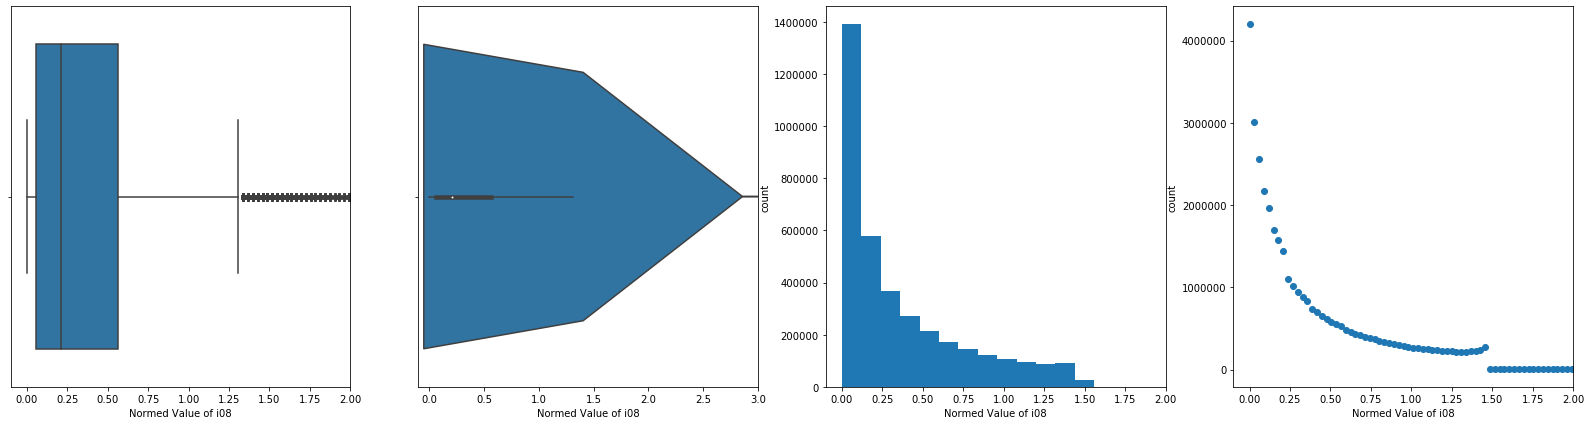

In [285]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i8_smpl['normed'])
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i08')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i8_smpl['normed'])
ax.set(xlim=(-0.1,3))
ax.set_xlabel('Normed Value of i08')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i8_smpl['normed'],bins=1200)
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i08')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i8_normed_counts['normed'],y=i8_normed_counts['count'])
ax.set(xlim=(-0.1,2))
ax.set_xlabel('Normed Value of i08')
ax.set_ylabel('count')

plt.show()

**Conclusion for i08**
- Exponentially decreasing distribution
- normalization here will consist of dividing by 2 times the std. deviation.

## i09

In [286]:
i9 = idf.select('i09').cache()

In [287]:
i9_counts = i9.groupBy('i09').count().toPandas()

In [288]:
i9_counts.sort_values(by=['count'],ascending=False,inplace=True)
i9_counts.head(15)

,i09,count
1451,NaN,1587427
3584,1.0,1370692
6649,0.0,1115938
1548,2.0,1109096
1819,3.0,923586
5797,4.0,810975
347,5.0,718390
3585,6.0,664517
1524,7.0,607501
3815,8.0,559583


In [289]:
i9_counts.shape

(6974, 2)

In [291]:
i9_hist = i9.select('i09').rdd.flatMap(lambda x: x).histogram(10000)

In [292]:
i9_values = i9_hist[0]
i9_values_count = i9_hist[1]
i9_values.pop(0)
print(f"lengths: i9values={len(i9_values)}, i9counts={len(i9_values_count)}")

lengths: i9values=10000, i9counts=10000


In [293]:
i9_smpl = i9.sample(fraction=0.1,seed=42).toPandas()

In [294]:
i9_smpl.describe()

,i09
count,3.506665e+06
mean,1.059837e+02
std,2.191765e+02
min,0.000000e+00
25%,1.000000e+01
50%,3.800000e+01
75%,1.100000e+02
max,1.279100e+04


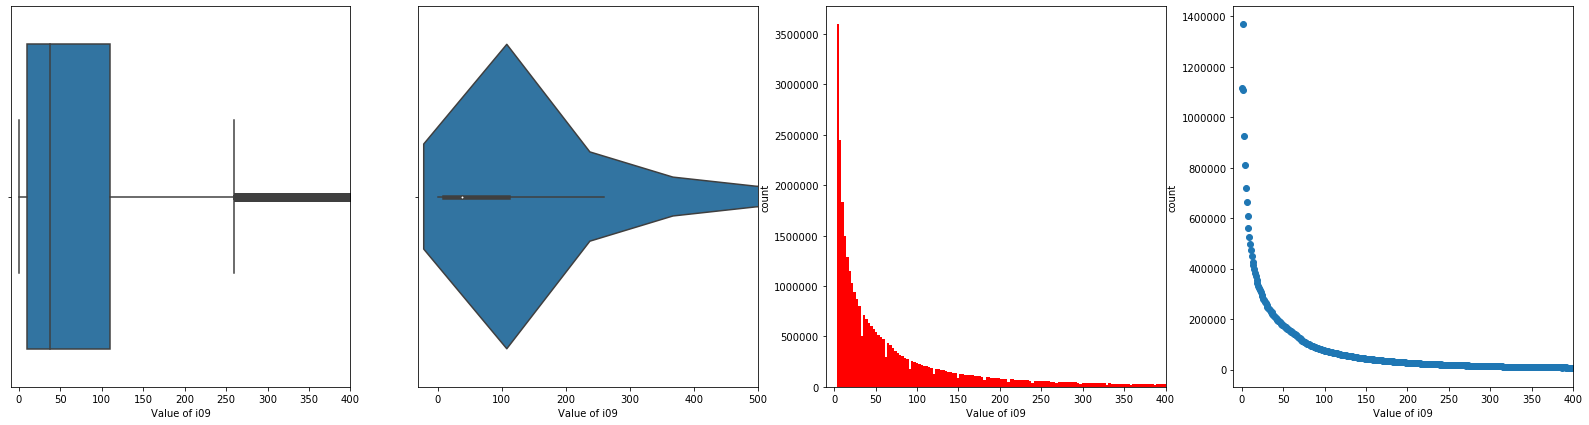

In [298]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i9_smpl)
ax.set(xlim=(-10,400))
ax.set_xlabel('Value of i09')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i9_smpl)
ax.set(xlim=(-30,500))
ax.set_xlabel('Value of i09')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i9_values,len(i9_values),weights=i9_values_count,color='red')
ax.set(xlim=(-10,400))
ax.set_xlabel('Value of i09')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i9_counts['i09'],y=i9_counts['count'])
ax.set(xlim=(-10,400))
ax.set_xlabel('Value of i09')
ax.set_ylabel('count')

plt.show()

In [299]:
i9_smpl['normed']=(i9_smpl['i09']-40)/(220.289905)
i9_smpl.describe()

,i09,normed
count,3.506665e+06,3.506665e+06
mean,1.059837e+02,2.995310e-01
std,2.191765e+02,9.949456e-01
min,0.000000e+00,-1.815789e-01
25%,1.000000e+01,-1.361842e-01
50%,3.800000e+01,-9.078945e-03
75%,1.100000e+02,3.177631e-01
max,1.279100e+04,5.788282e+01


In [300]:
i9_normed_counts = i9_counts

In [301]:
i9_normed_counts['normed']=(i9_normed_counts['i09']-40)/(220.289905)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


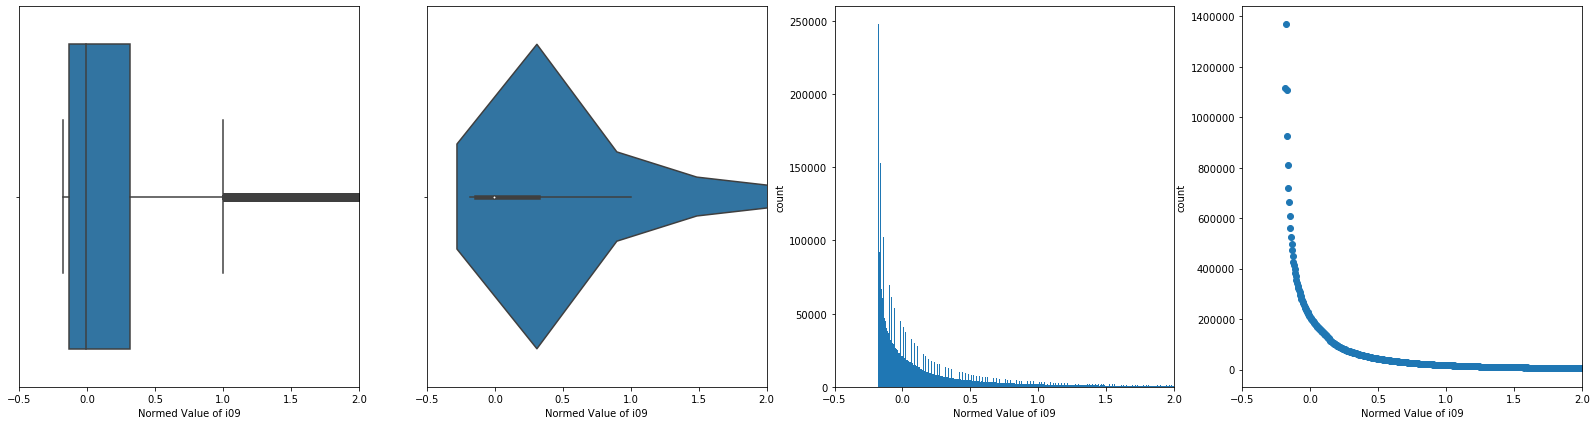

In [304]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i9_smpl['normed'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i09')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i9_smpl['normed'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i09')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i9_smpl['normed'],bins=10000)
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i09')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i9_normed_counts['normed'],y=i9_normed_counts['count'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i09')
ax.set_ylabel('count')

plt.show()

**Conclusion for i09**
- Violin plot: truncated skewed normal distribution.
- normalization here will consist of Z score using median instead of mean.

## i10

In [305]:
i10 = idf.select('i10').cache()

In [306]:
i10_counts = i10.groupBy('i10').count().toPandas()

In [307]:
i10_counts.sort_values(by=['count'],ascending=False,inplace=True)
i10_counts.head(15)

,i10,count
2,NaN,16637956
11,0.0,9570731
7,1.0,8894460
4,2.0,1297396
5,3.0,221583
10,4.0,41289
1,5.0,7879
8,6.0,1541
3,7.0,291
9,8.0,69


In [308]:
i10_counts.shape

(12, 2)

In [310]:
i10_hist = i10.select('i10').rdd.flatMap(lambda x: x).histogram(12)

In [311]:
i10_values = i10_hist[0]
i10_values_count = i10_hist[1]
i10_values.pop(0)
print(f"lengths: i10values={len(i10_values)}, i10counts={len(i10_values_count)}")

lengths: i10values=12, i10counts=12


In [314]:
i10_smpl = i10.toPandas()

In [315]:
i10_smpl.describe()

,i10
count,2.003525e+07
mean,6.174349e-01
std,6.839687e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+01


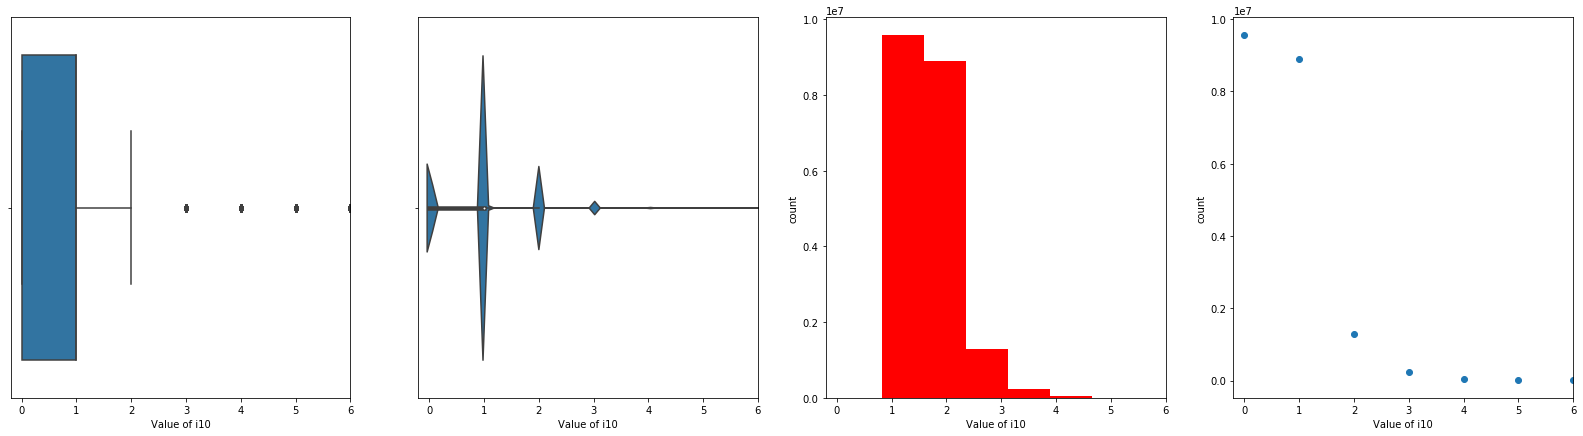

In [317]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i10_smpl)
ax.set(xlim=(-0.2,6))
ax.set_xlabel('Value of i10')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i10_smpl)
ax.set(xlim=(-0.2,6))
ax.set_xlabel('Value of i10')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i10_values,len(i10_values),weights=i10_values_count,color='red')
ax.set(xlim=(-0.2,6))
ax.set_xlabel('Value of i10')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i10_counts['i10'],y=i10_counts['count'])
ax.set(xlim=(-0.2,6))
ax.set_xlabel('Value of i10')
ax.set_ylabel('count')

plt.show()

In [318]:
i10_smpl['normed']=(i10_smpl['i10'])/(10)
i10_smpl.describe()

,i10,normed
count,2.003525e+07,2.003525e+07
mean,6.174349e-01,6.174346e-02
std,6.839687e-01,6.839688e-02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e-01
75%,1.000000e+00,1.000000e-01
max,1.000000e+01,1.000000e+00


In [319]:
i10_normed_counts = i10_counts

In [320]:
i10_normed_counts['normed']=(i10_normed_counts['i10'])/(10)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


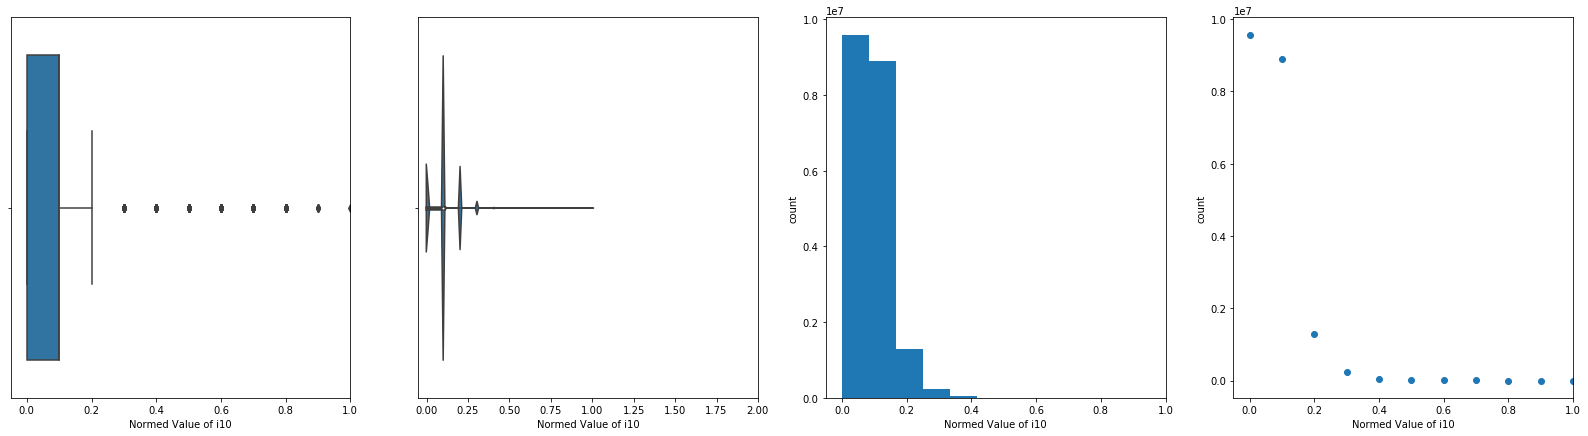

In [322]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i10_smpl['normed'])
ax.set(xlim=(-.05,1))
ax.set_xlabel('Normed Value of i10')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i10_smpl['normed'])
ax.set(xlim=(-.05,2))
ax.set_xlabel('Normed Value of i10')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i10_smpl['normed'],bins=12)
ax.set(xlim=(-.05,1))
ax.set_xlabel('Normed Value of i10')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i10_normed_counts['normed'],y=i10_normed_counts['count'])
ax.set(xlim=(-.05,1))
ax.set_xlabel('Normed Value of i10')
ax.set_ylabel('count')

plt.show()

**Conclusion for i10**
- almost sigmoid distribution.
- normalization here will consist of division by the maximum value only

## i11

In [323]:
i11 = idf.select('i11').cache()

In [324]:
i11_counts = i11.groupBy('i11').count().toPandas()

In [325]:
i11_counts.sort_values(by=['count'],ascending=False,inplace=True)
i11_counts.head(15)

,i11,count
85,1.0,12262080
162,0.0,8210640
44,2.0,5033882
49,3.0,2694168
139,4.0,1654474
39,NaN,1587427
9,5.0,1085115
86,6.0,774994
43,7.0,569669
90,8.0,437831


In [326]:
i11_counts.shape

(167, 2)

In [327]:
i11_hist = i11.select('i11').rdd.flatMap(lambda x: x).histogram(200)

In [328]:
i11_values = i11_hist[0]
i11_values_count = i11_hist[1]
i11_values.pop(0)
print(f"lengths: i11values={len(i11_values)}, i11counts={len(i11_values_count)}")

lengths: i11values=200, i11counts=200


In [329]:
i11_smpl = i11.sample(fraction=0.1,seed=42).toPandas()

In [330]:
i11_smpl.describe()

,i11
count,3.506665e+06
mean,2.726642e+00
std,5.186455e+00
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,1.600000e+02


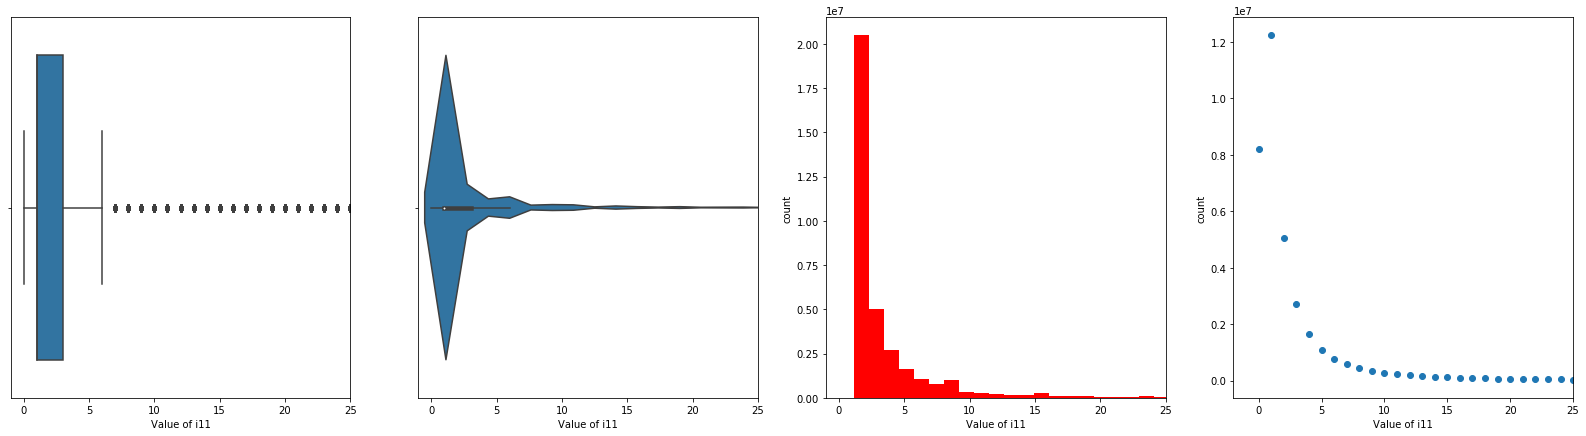

In [332]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i11_smpl)
ax.set(xlim=(-1,25))
ax.set_xlabel('Value of i11')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i11_smpl)
ax.set(xlim=(-1,25))
ax.set_xlabel('Value of i11')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i11_values,len(i11_values),weights=i11_values_count,color='red')
ax.set(xlim=(-1,25))
ax.set_xlabel('Value of i11')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i11_counts['i11'],y=i11_counts['count'])
ax.set(xlim=(-2,25))
ax.set_xlabel('Value of i11')
ax.set_ylabel('count')

plt.show()

In [333]:
i11_smpl['normed']=(i11_smpl['i11']-1)/(5.196922)
i11_smpl.describe()

,i11,normed
count,3.506665e+06,3.506665e+06
mean,2.726642e+00,3.322431e-01
std,5.186455e+00,9.979859e-01
min,0.000000e+00,-1.924216e-01
25%,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00
75%,3.000000e+00,3.848432e-01
max,1.600000e+02,3.059503e+01


In [334]:
i11_normed_counts = i11_counts

In [335]:
i11_normed_counts['normed']=(i11_normed_counts['i11']-1)/(5.196922)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


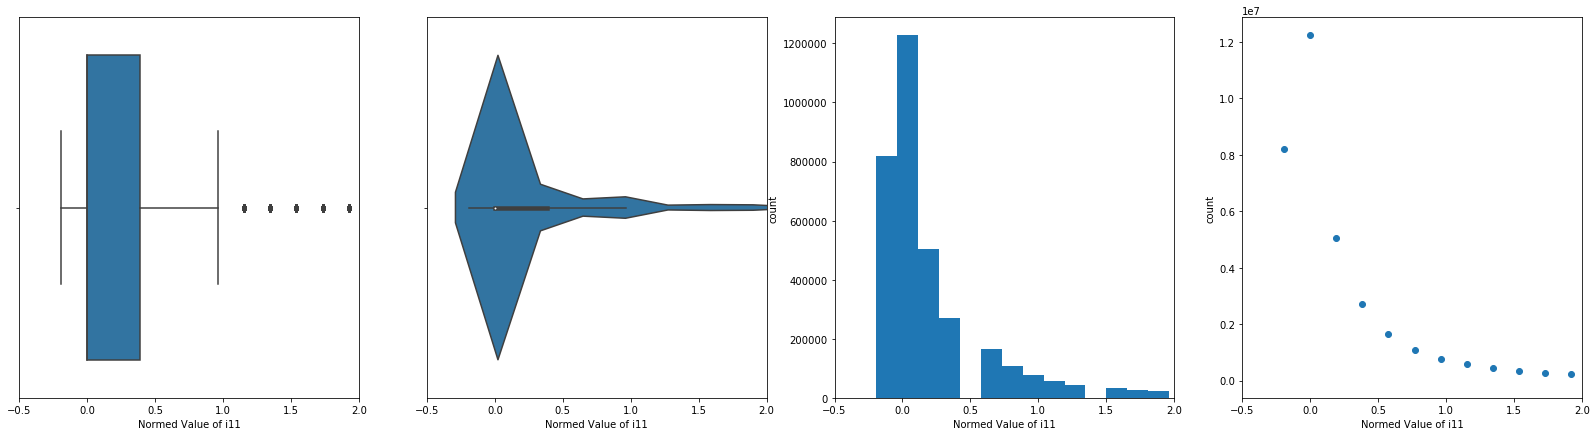

In [337]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i11_smpl['normed'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i11')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i11_smpl['normed'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i11')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i11_smpl['normed'],bins=200)
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i11')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i11_normed_counts['normed'],y=i11_normed_counts['count'])
ax.set(xlim=(-.5,2))
ax.set_xlabel('Normed Value of i11')
ax.set_ylabel('count')

plt.show()

**Conclusion for i11**
- Violin plot: truncated skewed normal distribution.
- normalization here will consist of Z score using median instead of mean.

## i12

In [338]:
i12 = idf.select('i12').cache()

In [339]:
i12_counts = i12.groupBy('i12').count().toPandas()

In [340]:
i12_counts.sort_values(by=['count'],ascending=False,inplace=True)
i12_counts.head(15)

,i12,count
91,NaN,28057242
369,0.0,6427752
199,1.0,1320200
97,2.0,294963
111,3.0,132231
315,4.0,79460
17,5.0,53894
200,6.0,40090
95,7.0,31117
210,8.0,25176


In [341]:
i12_counts.shape

(382, 2)

In [356]:
i12_hist = i12.select('i12').rdd.flatMap(lambda x: x).histogram(4000)

In [357]:
i12_values = i12_hist[0]
i12_values_count = i12_hist[1]
i12_values.pop(0)
print(f"lengths: i12values={len(i12_values)}, i12counts={len(i12_values_count)}")

lengths: i12values=4000, i12counts=4000


In [347]:
i12_smpl = i12.sample(fraction=0.1,seed=42).toPandas()

In [348]:
i12_smpl.describe()

,i12
count,860123.000000
mean,0.998882
std,6.721590
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,3770.000000


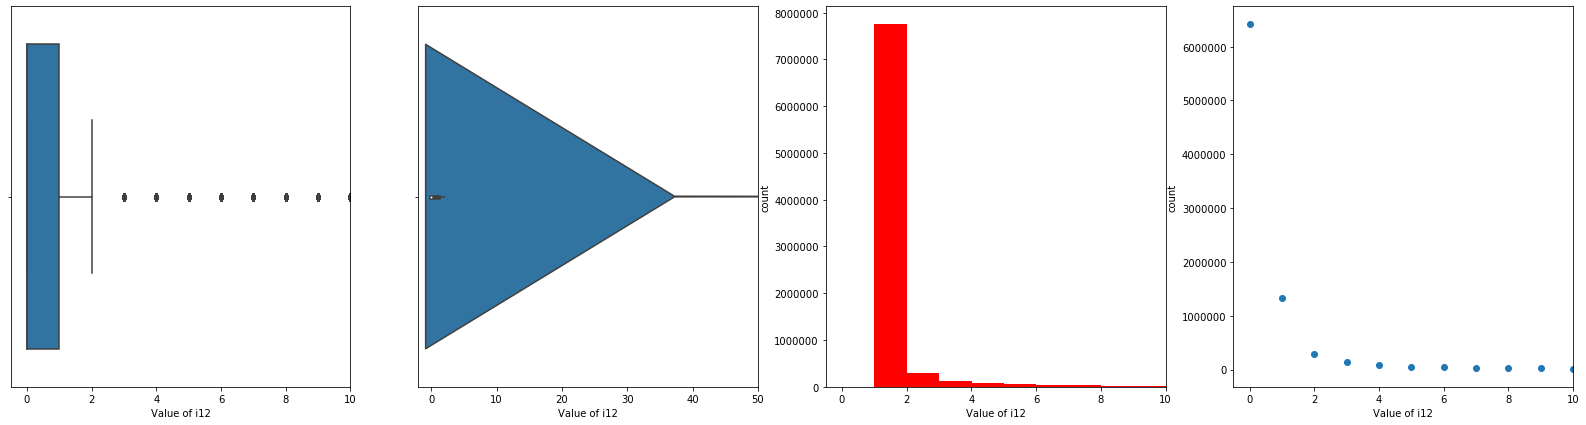

In [359]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i12_smpl)
ax.set(xlim=(-0.5,10))
ax.set_xlabel('Value of i12')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i12_smpl)
ax.set(xlim=(-2,50))
ax.set_xlabel('Value of i12')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i12_values,len(i12_values),weights=i12_values_count,color='red')
ax.set(xlim=(-0.5,10))
ax.set_xlabel('Value of i12')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i12_counts['i12'],y=i12_counts['count'])
ax.set(xlim=(-0.5,10))
ax.set_xlabel('Value of i12')
ax.set_ylabel('count')

plt.show()

In [360]:
i12_smpl['normed']=(i12_smpl['i12'])/(2*5.672792)
i12_smpl.describe()

,i12,normed
count,860123.000000,860123.000000
mean,0.998882,0.088041
std,6.721590,0.592441
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.088140
max,3770.000000,332.287875


In [363]:
i12_normed_counts = i12_counts

In [364]:
i12_normed_counts['normed']=(i12_normed_counts['i12'])/(2*5.672792)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


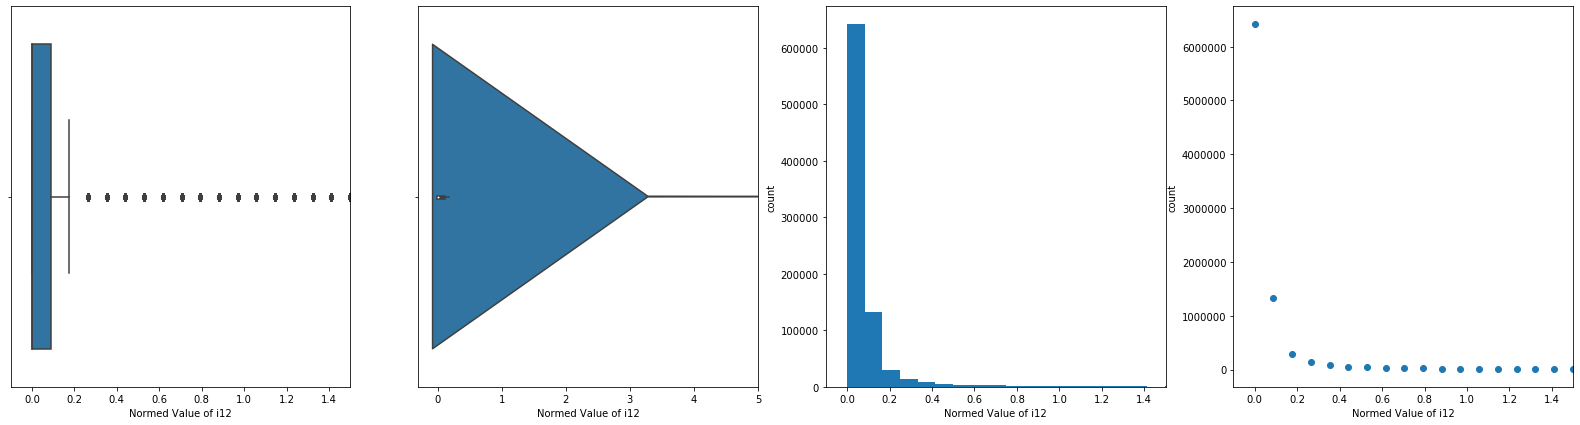

In [367]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i12_smpl['normed'])
ax.set(xlim=(-.1,1.5))
ax.set_xlabel('Normed Value of i12')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i12_smpl['normed'])
ax.set(xlim=(-.3,5))
ax.set_xlabel('Normed Value of i12')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i12_smpl['normed'],bins=4000)
ax.set(xlim=(-.1,1.5))
ax.set_xlabel('Normed Value of i12')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i12_normed_counts['normed'],y=i12_normed_counts['count'])
ax.set(xlim=(-.1,1.5))
ax.set_xlabel('Normed Value of i12')
ax.set_ylabel('count')

plt.show()

**Conclusion for i12**
- Violin plot: exponentially decreasing distribution.
- normalization here will consist of dividing by 2 times the std. deviation.

## i13

In [368]:
i13 = idf.select('i13').cache()

In [369]:
i13_counts = i13.groupBy('i13').count().toPandas()

In [370]:
i13_counts.sort_values(by=['count'],ascending=False,inplace=True)
i13_counts.head(15)

,i13,count
278,NaN,7949629
666,1.0,4648207
297,2.0,3561658
348,3.0,2686311
1052,4.0,2145251
1213,0.0,1823848
67,5.0,1698369
667,6.0,1436047
293,7.0,1177588
703,8.0,990229


In [371]:
i13_counts.shape

(1267, 2)

In [372]:
i13_hist = i13.select('i13').rdd.flatMap(lambda x: x).histogram(7000)

In [373]:
i13_values = i13_hist[0]
i13_values_count = i13_hist[1]
i13_values.pop(0)
print(f"lengths: i13values={len(i13_values)}, i13counts={len(i13_values_count)}")

lengths: i13values=7000, i13counts=7000


In [382]:
i13_smpl = i13.sample(fraction=0.25,seed=42).toPandas()

In [383]:
i13_smpl.describe()

,i13
count,7.178640e+06
mean,8.215812e+00
std,1.652668e+01
min,0.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,1.000000e+01
max,6.558000e+03


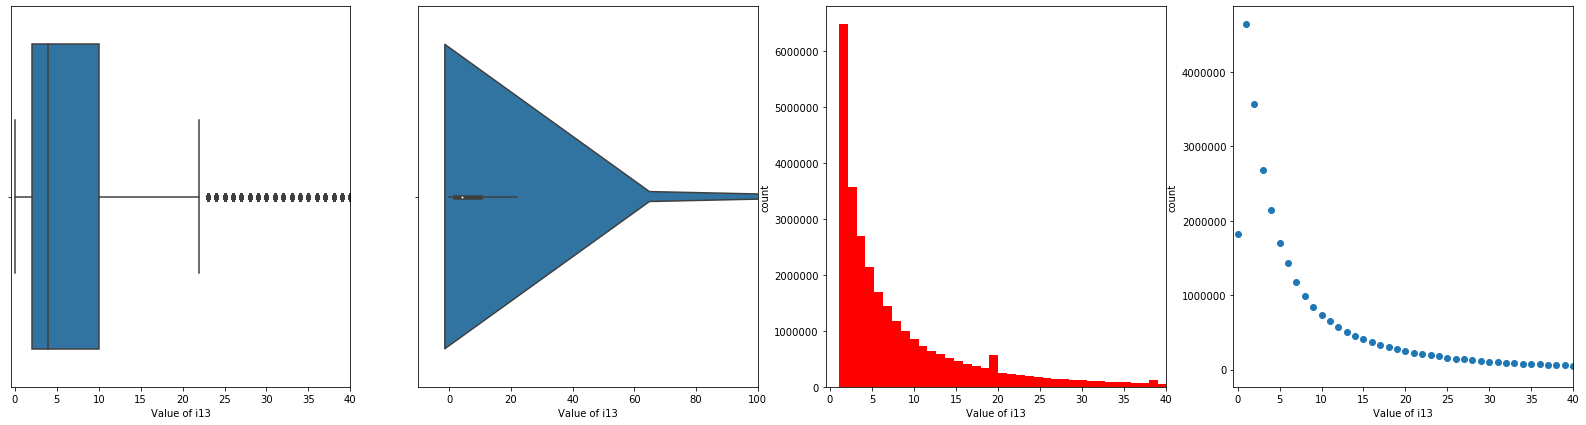

In [384]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i13_smpl)
ax.set(xlim=(-0.5,40))
ax.set_xlabel('Value of i13')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i13_smpl)
ax.set(xlim=(-10,100))
ax.set_xlabel('Value of i13')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i13_values,len(i13_values),weights=i13_values_count,color='red')
ax.set(xlim=(-0.5,40))
ax.set_xlabel('Value of i13')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i13_counts['i13'],y=i13_counts['count'])
ax.set(xlim=(-0.5,40))
ax.set_xlabel('Value of i13')
ax.set_ylabel('count')

plt.show()

In [385]:
i13_smpl['normed']=(i13_smpl['i13']-5)/(16.413245)
i13_smpl.describe()

,i13,normed
count,7.178640e+06,7.178640e+06
mean,8.215812e+00,1.959279e-01
std,1.652668e+01,1.006911e+00
min,0.000000e+00,-3.046320e-01
25%,2.000000e+00,-1.827792e-01
50%,4.000000e+00,-6.092640e-02
75%,1.000000e+01,3.046320e-01
max,6.558000e+03,3.992507e+02


In [386]:
i13_normed_counts = i13_counts

In [388]:
i13_normed_counts['normed']=(i13_normed_counts['i13']-5)/(16.413245)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


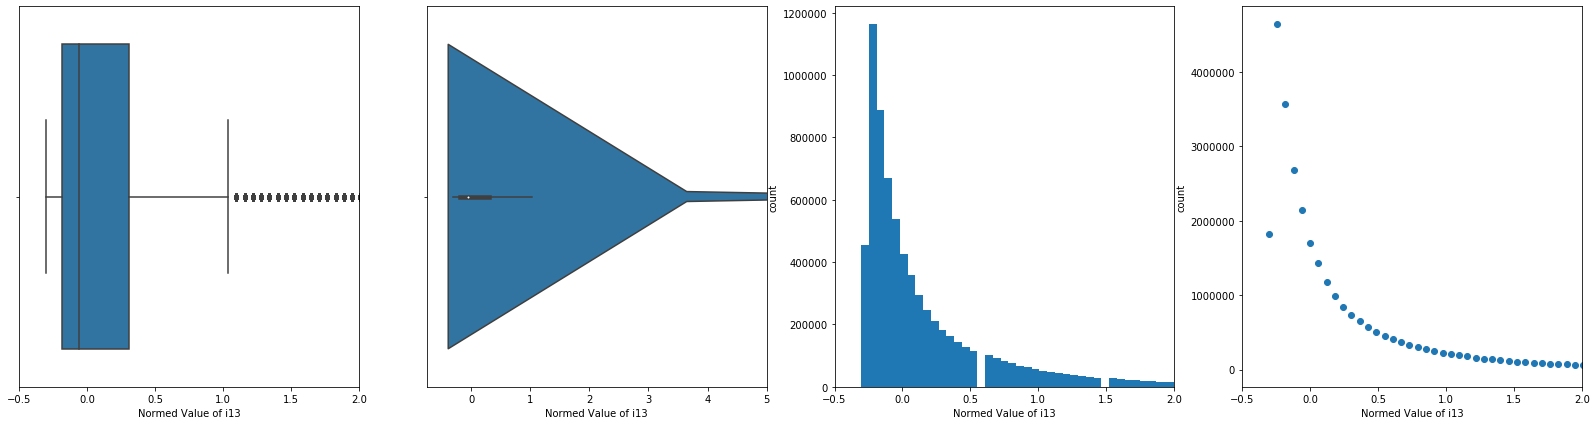

In [391]:
fig=plt.figure(figsize=(28,7))
# Box Plot
ax=fig.add_subplot(1,4,1)
ax=sns.boxplot(x=i13_smpl['normed'])
ax.set(xlim=(-0.5,2))
ax.set_xlabel('Normed Value of i13')

# Violin Plot
ax=fig.add_subplot(1,4,2)
ax=sns.violinplot(x=i13_smpl['normed'])
ax.set(xlim=(-0.75,5))
ax.set_xlabel('Normed Value of i13')

# Histogram
ax=fig.add_subplot(1,4,3)
ax.hist(i13_smpl['normed'],bins=7000)
ax.set(xlim=(-0.5,2))
ax.set_xlabel('Normed Value of i13')
ax.set_ylabel('count')

# ScatterPlot
ax=fig.add_subplot(1,4,4)
ax.scatter(x=i13_normed_counts['normed'],y=i13_normed_counts['count'])
ax.set(xlim=(-0.5,2))
ax.set_xlabel('Normed Value of i13')
ax.set_ylabel('count')

plt.show()

**Conclusion for i13**
- Violin plot: exponentially decreasing distribution, but the scatter plot and the bar chart look far more 'normally' distributed
- normalization here will be a Z-score, but with median instead of mean

# Toy Data

In [273]:
toy = pf.sample(fraction=0.000020, seed=2019).cache()

In [274]:
type(toy)

pyspark.sql.dataframe.DataFrame

In [275]:
toypdf =toy.toPandas()

In [276]:
toypdf.shape

(738, 40)

In [277]:
toy_cln = toypdf.dropna()

In [278]:
toy_cln.shape

(20, 40)

In [279]:
toy_cln

,ctr,i01,i02,i03,i04,i05,i06,i07,i08,i09,...,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26
78,0,0.0,1,15.0,16.0,1624.0,24.0,5.0,20.0,391.0,...,27c07bd6,c61e82d7,21ddcdc9,5840adea,ff3ce4c0,c9d4222a,423fab69,d691765a,445bbe3b,d1d45fc5
79,0,0.0,1,675.0,20.0,60.0,659.0,7.0,33.0,2256.0,...,e5ba7672,c21c3e4c,21ddcdc9,b1252a9d,cad88c3b,ad3062eb,bcdee96c,60a57787,9b3e8820,17723a96
97,0,0.0,1,8.0,4.0,1213.0,11.0,596.0,16.0,16.0,...,27c07bd6,e88ffc9d,2efde463,a458ea53,a23da47b,ad3062eb,c7dc6720,65c55747,cb079c2d,f868e7eb
133,0,0.0,-1,58.0,20.0,2728.0,152.0,7.0,15.0,298.0,...,27c07bd6,c21c3e4c,21ddcdc9,b1252a9d,29d21ab1,ad3062eb,bcdee96c,69e4f188,e8b83407,bb574173
217,1,6.0,15,1.0,4.0,89.0,4.0,72.0,24.0,125.0,...,3486227d,07070d63,21ddcdc9,5840adea,e5195a68,c9d4222a,32c7478e,9be5c7a4,2bf691b1,2fede552
227,1,7.0,116,8.0,3.0,1405.0,3.0,40.0,3.0,54.0,...,3486227d,1f868fdd,1d04f4a4,a458ea53,b2387ac1,ad3062eb,3a171ecb,3fdb382b,9d93af03,49d68486
298,1,2.0,0,10.0,1.0,1448.0,28.0,5.0,28.0,40.0,...,e5ba7672,8f0f692f,21ddcdc9,a458ea53,cc6a9262,ad3062eb,32c7478e,a5862ce8,445bbe3b,00dc9eff
321,1,0.0,91,2.0,4.0,2306.0,14.0,10.0,13.0,16.0,...,e5ba7672,395856b0,21ddcdc9,a458ea53,c9ffd163,ad3062eb,3a171ecb,77f43467,001f3601,7ad8ec78
344,0,9.0,1,31.0,21.0,1317.0,28.0,95.0,23.0,420.0,...,3486227d,5aed7436,03a07a24,a458ea53,20ae75f1,ad3062eb,c7dc6720,3fdb382b,e8b83407,49d68486
371,0,2.0,28,5.0,3.0,149.0,14.0,11.0,29.0,428.0,...,8efede7f,395856b0,21ddcdc9,b1252a9d,09192c91,ad3062eb,3a171ecb,abd6caea,001f3601,aae032ad


In [280]:
toy_cln.to_pickle('../data/ToyData.pkl')

### Vinicio: Why use pickle for the Toy? It could be better to keep it in parquet? or csv?